In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import math
import csv
from PIL import Image
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime

Using TensorFlow backend.
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\robotics\anaconda3\envs\faster_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\robotics\an

In [2]:
ratio = 4
channels = 3
HR_size = np.array([480,640])#
LR_size = HR_size // ratio
H_h = HR_size[0]
H_w = HR_size[1]
L_h = LR_size[0]
L_w = LR_size[1]

print(HR_size[0])
print(LR_size)

480
[120 160]


In [3]:
class DataLoader():
    def __init__(self):
        pass
#         self.ratio = ratio
#         self.HR_size = HR_size
#         self.LR_size = HR_size / ratio
#         self.H_h = HR_size[0]
#         self.H_w = HR_size[1]
#         self.L_h = LR_size[0]
#         self.L_h = LR_size[1]
        
    
    
    def load_data(self, batch_size = 1):
        files = glob.glob("../../images/train/*.png", recursive=True)
        batch_images = random.sample(files, batch_size)
    
        HR_images = []
        LR_images = []
    
        for img_path in batch_images:
            img = Image.open(img_path)

            HR_image = img.resize((H_w, H_h))  #(64, 64)
            LR_image = img.resize((L_w, L_h))
            HR_image = np.array(HR_image)
            #img_hr = (img_hr - 127.5) / 127.5
            LR_image = np.array(LR_image)
            #img_lr = (img_lr - 127.5) / 127.5

#             if not is_testing and np.random.random() < 0.5:
#                 img_hr = np.fliplr(img_hr)
#                 img_lr = np.fliplr(img_lr)

            HR_images.append(HR_image)
            LR_images.append(LR_image)
        
        HR_images = np.array(HR_images) / 127.5 - 1
        LR_images = np.array(LR_images) / 127.5 - 1
        
        return HR_images, LR_images

#------------------------------------------------------------------#
  
#------------------------------------------------------------------#

class predDataLoader():          
    def load_data(self, batch_size, counter):
        random.seed(counter)
        np.random.seed(counter)

        files = glob.glob("../../images/test/*.png", recursive=True)
        batch_images = random.sample(files, batch_size)

        imgs_or = []
        for img_path in batch_images:
            img = Image.open(img_path)

            img_or = np.array(img)
            imgs_or.append(img_or)

        imgs_or = np.array(imgs_or) / 127.5 - 1.

        return imgs_or
    
    
#------------------------------------------------------------------#
  
#------------------------------------------------------------------#

class SRGAN():
    def __init__(self):
        
        # Input shape
#         self.channels = 3
#         self.lr_height = 288                 # Low resolution height
#         self.lr_width = 384                  # Low resolution width
#         self.lr_shape = (self.lr_height, self.lr_width, self.channels)
#         resLevel = 2 #
#         self.hr_height = self.lr_height*resLevel  # High resolution height
#         self.hr_width = self.lr_width*resLevel     # High resolution width
#         self.hr_shape = (self.hr_height, self.hr_width, self.channels)

        #残差ブロックの数
        # Number of residual blocks in the generator
        self.n_residual_blocks = 16 #

        optimizer = Adam(0.0002, 0.5)

        #img_hrの特徴量をVGG19で算出する
        # We use a pre-trained VGG19 model to extract image features from the high resolution
        # and the generated high resolution images and minimize the mse between them
        self.VGG = self.build_vgg()
        self.VGG.trainable = False
        self.VGG.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        
        #データはここで読み込まれる
        # Configure data loader
        #self.dataset_name = 'img_align_celeba'
        self.data_loader = DataLoader()
        self.pred_data_loader = predDataLoader()

        #Dのサイズ
        # Calculate output shape of D (PatchGAN)
        patchH = int(H_h / 2**4) #
        patchW = int(H_w / 2**4) #
        self.disc_patch = (patchH, patchW, 1) 

        #DとGのチャンネル設定
        # Number of filters in the first layer of G and D
        self.gf = 60 #gf
        self.df = 60 #df
        #Dビルドとコンパイル
        # Build and compile the discriminator
        self.Discriminator = self.build_discriminator()
        self.Discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #Gのビルド
        # Build the generator
        self.Generator = self.build_generator()

        # High res. and low res. images
        HR_image = Input(shape = (H_h, H_w, channels))
        LR_image = Input(shape = (L_h, L_w, channels))

        #Gで生成されたhrのimg
        # Generate high res. version from low res.
        SR_image = self.Generator(LR_image)

        #hrのimgの特徴量の算出
        # Extract image features of the generated img
        SR_features = self.VGG(SR_image)

        # For the combined model we will only train the generator
        self.Discriminator.trainable = False

        #学習モデルコンパイル
        # Discriminator determines validity of generated high res. images
        validity = self.Discriminator(SR_image)

        self.combined = Model([LR_image, HR_image], [validity, SR_features])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1],
                              optimizer=optimizer)
        
    #------------------------------------------------------------------#
    
    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features extracted at the
        third block of the model
        """
        VGG = VGG19(weights="imagenet")
        # Set outputs to outputs of last conv. layer in block 3
        # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
        VGG.outputs = [VGG.layers[9].output]

        img = Input(shape = (H_h, H_w, channels))

        # Extract image features
        img_features = VGG(img)

        return Model(img, img_features)
    
    #------------------------------------------------------------------#
    
    #Generator の実装
    def build_generator(self):

        #残差ブロックの中身
        def residual_block(layer_input, n_filters):
            """Residual block described in paper"""
            d = Conv2D(n_filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(n_filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        #解像度を2倍にするUpSampling
        def deconv2d(layer_input):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input) #
            u = Conv2D(120, kernel_size=3, strides=1, padding='same')(u) #
            u = Activation('relu')(u)
            return u

        # Low resolution image input
        img_lr = Input(shape = (L_h, L_w, channels))

        # Pre-residual block
        c1 = Conv2D(60, kernel_size=9, strides=1, padding='same')(img_lr) #
        c1 = Activation('relu')(c1)

        # Propogate through residual blocks
        r = residual_block(c1, self.gf)
        for _ in range(self.n_residual_blocks - 1):
            r = residual_block(r, self.gf)

        #去の残差ブロックと組み合わせる
        # Post-residual block
        c2 = Conv2D(60, kernel_size=3, strides=1, padding='same')(r) #
        c2 = BatchNormalization(momentum=0.8)(c2)
        c2 = Add()([c2, c1])

        # Upsampling
        n = ratio
        while(n % 2 == 0):
            c2 = deconv2d(c2)
            n = n // 2

        # Generate high resolution output
        gen_hr = Conv2D(channels, kernel_size=9, strides=1, padding='same', activation='tanh')(c2)

        return Model(img_lr, gen_hr)
    
    
    #------------------------------------------------------------------#
    
    #Discriminator の実装
    def build_discriminator(self):

        
        def d_block(layer_input, filters, strides=1, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        # Input img
        d0 = Input(shape = (H_h, H_w, channels))
        #畳み込み層、チャンネル数を最終的に16倍に
        d1 = d_block(d0, self.df, bn=False)
        d2 = d_block(d1, self.df, strides=2)
        d3 = d_block(d2, self.df*2)
        d4 = d_block(d3, self.df*2, strides=2)
        d5 = d_block(d4, self.df*4)
        d6 = d_block(d5, self.df*4, strides=2)
        d7 = d_block(d6, self.df*8)
        d8 = d_block(d7, self.df*8, strides=2)
        #この時点で画像サイズ1/16
        d9 = Dense(self.df*16)(d8)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1, activation='sigmoid')(d10)

        return Model(d0, validity)
    
    
    #------------------------------------------------------------------#
    
    
    #学習
    def train(self, epochs, batch_size, sample_interval=100):

        start_time = datetime.datetime.now()
        psnr_file = open('psnr.csv' , 'w+')
        psnr_file.close()
        

        for epoch in range(epochs):

            # ----------------------
            #  Train Discriminator
            # ----------------------

            # Sample images and their conditioning counterparts
            HR_images, LR_images = self.data_loader.load_data(batch_size)

            # From low res. image generate high res. version
            SR_images = self.Generator.predict(LR_images)

            valid = np.ones((batch_size,) + self.disc_patch)#教師データ
            fake = np.zeros((batch_size,) + self.disc_patch)#教師データ

            #Dのloss
            # Train the discriminators (original images = real / generated = Fake)
            d_loss_real = self.Discriminator.train_on_batch(HR_images, valid)
            d_loss_fake = self.Discriminator.train_on_batch(SR_images, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------

            # Sample images and their conditioning counterparts
           
            #HR_images, LR_images = self.data_loader.load_data(batch_size)

            # The generators want the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.disc_patch)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.VGG.predict(HR_images)

            # Train the generators
            g_loss = self.combined.train_on_batch([LR_images, HR_images], [valid, image_features])

            elapsed_time = datetime.datetime.now() - start_time
            # Plot the progress
            print ("%d time: %s" % (epoch, elapsed_time))

            # If at save interval => save generated image samples
            if (epoch + 1) % sample_interval == 0:
                HR_images, LR_images, SR_images = self.sample_images(epoch+1, HR_images, LR_images, SR_images, batch_size)
                self.Generator.save_weights('srg_weight.h5')
                
                cv2.imwrite("../../images/images/{}_HR_image.png".format(epoch+1),HR_images[0])
                cv2.imwrite("../../images/images/{}_LR_image.png".format(epoch+1),LR_images[0])
                cv2.imwrite("../../images/images/{}_SR_image.png".format(epoch+1),SR_images[0])
                
                
    #------------------------------------------------------------------#
            
            
    
    #------------------------------------------------------------------#
    
    
    def sample_images(self, epoch, imgs_hr, imgs_lr, fake_hr, n):
        def denormalize(input_data):
            input_data = (input_data + 1) * 127.5
            return input_data.astype(np.uint8)
        

        imgs_lr = denormalize(imgs_lr)
        fake_hr = denormalize(fake_hr)
        imgs_hr = denormalize(imgs_hr)

        def psnr_calc(img1: np.ndarray, img2: np.ndarray, upscaling=8):
            def convert(img):
                return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            def extract_y(image: np.ndarray) -> np.ndarray:
                if image.ndim == 2:
                    return image
                image = image.astype(np.int32)
                return ((image[:, :, 2] * 65.481 / 255.
                          + image[:, :, 1] * 128.553 / 255.
                          + image[:, :, 0] * 24.966 / 255.) + 16).astype(np.int32)


            def psnr(img1, img2):
                mse = np.mean((img1 - img2) ** 2)
                if mse == 0:
                    return 100
                PIXEL_MAX = 255.0
                return 10 * math.log10(PIXEL_MAX * PIXEL_MAX / mse)
  
            img1_conv=convert(img1)
            img2_conv=convert(img2)
  
            # BGR -> YCrCb
            # 画像はcv2.imreadで読まれている前提 [0, 255]
            y1 = extract_y(img1_conv)
            y2 = extract_y(img2_conv)
            # 周囲のcropping
            # assert y1.shape == y2.shape
            h, w = y1.shape
            cr = upscaling
            cropped_y1 = y1[cr:h - cr, cr:w - cr].astype(np.float64)
            cropped_y2 = y2[cr:h - cr, cr:w - cr].astype(np.float64)

            # psnr
            psnr_val = psnr(cropped_y1, cropped_y2)
            return psnr_val
        
        
        # size=(480,480)
        psnr = 0
        print(psnr_calc(imgs_hr[0], fake_hr[0]))
        for i in range(n):
            psnr += psnr_calc(imgs_hr[i],fake_hr[i])
        
        m_psnr = psnr / n
        print(m_psnr)
        data =[epoch,m_psnr]
        psnr_file = open('psnr.csv' , 'a')
        writer = csv.writer(psnr_file, lineterminator='\n')  
        writer.writerow(data)
        psnr_file.close()
            
        return imgs_hr, imgs_lr, fake_hr
    

In [4]:
if __name__ == '__main__':
    gan = SRGAN()
    #gan = load_model("srg_weight.h5")
    gan.train(epochs=50000, batch_size=1, sample_interval=50)





Instructions for updating:
keep_dims is deprecated, use keepdims instead




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
0 time: 0:00:20.397909
1 time: 0:00:20.981936
2 time: 0:00:21.563464
3 time: 0:00:22.144993
4 time: 0:00:22.715511
5 time: 0:00:23.296545
6 time: 0:00:23.881077
7 time: 0:00:24.444589
8 time: 0:00:25.026118
9 time: 0:00:25.613156
10 time: 0:00:26.190681
11 time: 0:00:26.758197
12 time: 0:00:27.342728
13 time: 0:00:27.926260
14 time: 0:00:28.490277
15 time: 0:00:29.075810
16 time: 0:00:29.657339
17 time: 0:00:30.229860
18 time: 0:00:30.802884
19 time: 0:00:31.384413
20 time: 0:00:31.965942
21 time: 0:00:32.532457
22 time: 0:00:33.115988
23 time: 0:00:33.700023
24 time: 0:00:34.269542
25 time: 0:00:34.842061
26 time: 0:00:35.425096
27 time: 0:00:36.005130
28 time: 0:00:36.571150
29 time: 0:00:37.1536

214 time: 0:02:37.269804
215 time: 0:02:37.853840
216 time: 0:02:38.420355
217 time: 0:02:39.004387
218 time: 0:02:39.588920
219 time: 0:02:40.167445
220 time: 0:02:40.732959
221 time: 0:02:41.316490
222 time: 0:02:41.901524
223 time: 0:02:42.466542
224 time: 0:02:43.050072
225 time: 0:02:43.631601
226 time: 0:02:44.206124
227 time: 0:02:44.779152
228 time: 0:02:45.365685
229 time: 0:02:45.947214
230 time: 0:02:46.513731
231 time: 0:02:47.098765
232 time: 0:02:47.681295
233 time: 0:02:48.253816
234 time: 0:02:48.830845
235 time: 0:02:49.417379
236 time: 0:02:50.001236
237 time: 0:02:50.569753
238 time: 0:02:51.155286
239 time: 0:02:51.740827
240 time: 0:02:52.308343
241 time: 0:02:52.886868
242 time: 0:02:53.472402
243 time: 0:02:54.058439
244 time: 0:02:54.624954
245 time: 0:02:55.212489
246 time: 0:02:55.798528
247 time: 0:02:56.364043
248 time: 0:02:56.947076
249 time: 0:02:57.531607
24.28452444800741
24.28452444800741
250 time: 0:02:58.267254
251 time: 0:02:58.846781
252 time: 0:02

533 time: 0:05:42.996364
534 time: 0:05:43.579894
535 time: 0:05:44.160423
536 time: 0:05:44.734448
537 time: 0:05:45.323984
538 time: 0:05:45.910517
539 time: 0:05:46.478034
540 time: 0:05:47.061070
541 time: 0:05:47.644600
542 time: 0:05:48.219123
543 time: 0:05:48.793147
544 time: 0:05:49.379680
545 time: 0:05:49.963210
546 time: 0:05:50.530727
547 time: 0:05:51.113257
548 time: 0:05:51.698789
549 time: 0:05:52.270811
21.86552818078685
21.86552818078685
550 time: 0:05:53.017422
551 time: 0:05:53.600952
552 time: 0:05:54.179984
553 time: 0:05:54.749502
554 time: 0:05:55.332538
555 time: 0:05:55.917575
556 time: 0:05:56.487093
557 time: 0:05:57.072638
558 time: 0:05:57.653166
559 time: 0:05:58.229193
560 time: 0:05:58.827737
561 time: 0:05:59.415271
562 time: 0:05:59.998803
563 time: 0:06:00.567320
564 time: 0:06:01.154356
565 time: 0:06:01.742890
566 time: 0:06:02.313914
567 time: 0:06:02.895444
568 time: 0:06:03.476479
569 time: 0:06:04.062011
570 time: 0:06:04.629526
571 time: 0:06

851 time: 0:08:48.327028
852 time: 0:08:48.908558
853 time: 0:08:49.492088
854 time: 0:08:50.074617
855 time: 0:08:50.639132
856 time: 0:08:51.226112
857 time: 0:08:51.807641
858 time: 0:08:52.374156
859 time: 0:08:52.958192
860 time: 0:08:53.540722
861 time: 0:08:54.119750
862 time: 0:08:54.686265
863 time: 0:08:55.269302
864 time: 0:08:55.851832
865 time: 0:08:56.415344
866 time: 0:08:57.003385
867 time: 0:08:57.593922
868 time: 0:08:58.169951
869 time: 0:08:58.740469
870 time: 0:08:59.326504
871 time: 0:08:59.909034
872 time: 0:09:00.470545
873 time: 0:09:01.052075
874 time: 0:09:01.633604
875 time: 0:09:02.210127
876 time: 0:09:02.785151
877 time: 0:09:03.365679
878 time: 0:09:03.951213
879 time: 0:09:04.519730
880 time: 0:09:05.101764
881 time: 0:09:05.685294
882 time: 0:09:06.256319
883 time: 0:09:06.833845
884 time: 0:09:07.425383
885 time: 0:09:08.011417
886 time: 0:09:08.577934
887 time: 0:09:09.160463
888 time: 0:09:09.743993
889 time: 0:09:10.310022
890 time: 0:09:10.887548


1164 time: 0:11:50.538980
1165 time: 0:11:51.124018
1166 time: 0:11:51.705546
1167 time: 0:11:52.277066
1168 time: 0:11:52.851092
1169 time: 0:11:53.442132
1170 time: 0:11:54.076203
1171 time: 0:11:54.632709
1172 time: 0:11:55.191721
1173 time: 0:11:55.752231
1174 time: 0:11:56.311244
1175 time: 0:11:56.868751
1176 time: 0:11:57.427259
1177 time: 0:11:57.985766
1178 time: 0:11:58.542502
1179 time: 0:11:59.107016
1180 time: 0:11:59.667950
1181 time: 0:12:00.223455
1182 time: 0:12:00.779961
1183 time: 0:12:01.338469
1184 time: 0:12:01.896977
1185 time: 0:12:02.452482
1186 time: 0:12:03.011990
1187 time: 0:12:03.570004
1188 time: 0:12:04.127511
1189 time: 0:12:04.681014
1190 time: 0:12:05.243526
1191 time: 0:12:05.805036
1192 time: 0:12:06.358043
1193 time: 0:12:06.917552
1194 time: 0:12:07.476059
1195 time: 0:12:08.035569
1196 time: 0:12:08.591186
1197 time: 0:12:09.150695
1198 time: 0:12:09.725218
1199 time: 0:12:10.278721
26.27852283319794
26.27852283319794
1200 time: 0:12:10.996284
12

1471 time: 0:14:43.317093
1472 time: 0:14:43.873708
1473 time: 0:14:44.418407
1474 time: 0:14:44.975358
1475 time: 0:14:45.550935
1476 time: 0:14:46.112373
1477 time: 0:14:46.656420
1478 time: 0:14:47.225351
1479 time: 0:14:47.784940
1480 time: 0:14:48.336564
1481 time: 0:14:48.888674
1482 time: 0:14:49.461841
1483 time: 0:14:50.020311
1484 time: 0:14:50.578380
1485 time: 0:14:51.138873
1486 time: 0:14:51.696465
1487 time: 0:14:52.246936
1488 time: 0:14:52.807587
1489 time: 0:14:53.364558
1490 time: 0:14:53.925613
1491 time: 0:14:54.481953
1492 time: 0:14:55.028139
1493 time: 0:14:55.604193
1494 time: 0:14:56.159501
1495 time: 0:14:56.715057
1496 time: 0:14:57.273934
1497 time: 0:14:57.826631
1498 time: 0:14:58.386965
1499 time: 0:14:58.949171
20.76814956237286
20.76814956237286
1500 time: 0:14:59.656901
1501 time: 0:15:00.226818
1502 time: 0:15:00.779222
1503 time: 0:15:01.335688
1504 time: 0:15:01.908260
1505 time: 0:15:02.462463
1506 time: 0:15:03.021146
1507 time: 0:15:03.581916
15

1778 time: 0:17:35.609291
1779 time: 0:17:36.165351
1780 time: 0:17:36.729618
1781 time: 0:17:37.288042
1782 time: 0:17:37.847400
1783 time: 0:17:38.391284
1784 time: 0:17:38.957256
1785 time: 0:17:39.517236
1786 time: 0:17:40.075698
1787 time: 0:17:40.628698
1788 time: 0:17:41.188103
1789 time: 0:17:41.745979
1790 time: 0:17:42.291139
1791 time: 0:17:42.858728
1792 time: 0:17:43.405484
1793 time: 0:17:43.977544
1794 time: 0:17:44.531806
1795 time: 0:17:45.092102
1796 time: 0:17:45.657550
1797 time: 0:17:46.202236
1798 time: 0:17:46.768124
1799 time: 0:17:47.326490
22.10267510230649
22.10267510230649
1800 time: 0:17:48.048596
1801 time: 0:17:48.615023
1802 time: 0:17:49.161013
1803 time: 0:17:49.720354
1804 time: 0:17:50.286534
1805 time: 0:17:50.850580
1806 time: 0:17:51.398521
1807 time: 0:17:51.971938
1808 time: 0:17:52.526884
1809 time: 0:17:53.087046
1810 time: 0:17:53.645242
1811 time: 0:17:54.199409
1812 time: 0:17:54.758846
1813 time: 0:17:55.307880
1814 time: 0:17:55.863426
18

2085 time: 0:20:27.899813
2086 time: 0:20:28.465719
2087 time: 0:20:29.025056
2088 time: 0:20:29.585050
2089 time: 0:20:30.127063
2090 time: 0:20:30.693367
2091 time: 0:20:31.249770
2092 time: 0:20:31.806701
2093 time: 0:20:32.368852
2094 time: 0:20:32.931786
2095 time: 0:20:33.491255
2096 time: 0:20:34.051621
2097 time: 0:20:34.607354
2098 time: 0:20:35.155474
2099 time: 0:20:35.711790
29.161782255291065
29.161782255291065
2100 time: 0:20:36.432417
2101 time: 0:20:36.992994
2102 time: 0:20:37.551393
2103 time: 0:20:38.108013
2104 time: 0:20:38.653199
2105 time: 0:20:39.225893
2106 time: 0:20:39.769457
2107 time: 0:20:40.335858
2108 time: 0:20:40.895369
2109 time: 0:20:41.457011
2110 time: 0:20:42.009304
2111 time: 0:20:42.571905
2112 time: 0:20:43.120866
2113 time: 0:20:43.678411
2114 time: 0:20:44.233790
2115 time: 0:20:44.802090
2116 time: 0:20:45.362416
2117 time: 0:20:45.921671
2118 time: 0:20:46.477943
2119 time: 0:20:47.024814
2120 time: 0:20:47.583729
2121 time: 0:20:48.144572


2392 time: 0:23:20.317633
2393 time: 0:23:20.874261
2394 time: 0:23:21.431796
2395 time: 0:23:22.009143
2396 time: 0:23:22.563177
2397 time: 0:23:23.115234
2398 time: 0:23:23.672566
2399 time: 0:23:24.240386
24.42217187020615
24.42217187020615
2400 time: 0:23:24.971914
2401 time: 0:23:25.529559
2402 time: 0:23:26.086133
2403 time: 0:23:26.639336
2404 time: 0:23:27.198716
2405 time: 0:23:27.762766
2406 time: 0:23:28.326165
2407 time: 0:23:28.889193
2408 time: 0:23:29.441204
2409 time: 0:23:29.998752
2410 time: 0:23:30.563961
2411 time: 0:23:31.122320
2412 time: 0:23:31.679361
2413 time: 0:23:32.232006
2414 time: 0:23:32.793581
2415 time: 0:23:33.352685
2416 time: 0:23:33.913229
2417 time: 0:23:34.460759
2418 time: 0:23:35.018204
2419 time: 0:23:35.574967
2420 time: 0:23:36.132426
2421 time: 0:23:36.700209
2422 time: 0:23:37.257456
2423 time: 0:23:37.827912
2424 time: 0:23:38.376573
2425 time: 0:23:38.932994
2426 time: 0:23:39.490412
2427 time: 0:23:40.048367
2428 time: 0:23:40.614839
24

2699 time: 0:26:12.789042
22.765483036940495
22.765483036940495
2700 time: 0:26:13.516599
2701 time: 0:26:14.079655
2702 time: 0:26:14.621543
2703 time: 0:26:15.181030
2704 time: 0:26:15.739301
2705 time: 0:26:16.304342
2706 time: 0:26:16.865868
2707 time: 0:26:17.428449
2708 time: 0:26:17.990823
2709 time: 0:26:18.549412
2710 time: 0:26:19.108373
2711 time: 0:26:19.670399
2712 time: 0:26:20.216309
2713 time: 0:26:20.784023
2714 time: 0:26:21.341181
2715 time: 0:26:21.898181
2716 time: 0:26:22.446146
2717 time: 0:26:23.020060
2718 time: 0:26:23.577274
2719 time: 0:26:24.133882
2720 time: 0:26:24.696710
2721 time: 0:26:25.255276
2722 time: 0:26:25.814256
2723 time: 0:26:26.364780
2724 time: 0:26:26.929139
2725 time: 0:26:27.490823
2726 time: 0:26:28.049052
2727 time: 0:26:28.595807
2728 time: 0:26:29.152846
2729 time: 0:26:29.709221
2730 time: 0:26:30.275721
2731 time: 0:26:30.834803
2732 time: 0:26:31.395677
2733 time: 0:26:31.955717
2734 time: 0:26:32.512254
2735 time: 0:26:33.070096


3005 time: 0:29:04.898685
3006 time: 0:29:05.456606
3007 time: 0:29:06.019018
3008 time: 0:29:06.576536
3009 time: 0:29:07.135507
3010 time: 0:29:07.684041
3011 time: 0:29:08.252000
3012 time: 0:29:08.812359
3013 time: 0:29:09.370157
3014 time: 0:29:09.929458
3015 time: 0:29:10.484013
3016 time: 0:29:11.029319
3017 time: 0:29:11.603158
3018 time: 0:29:12.147248
3019 time: 0:29:12.714611
3020 time: 0:29:13.271472
3021 time: 0:29:13.845747
3022 time: 0:29:14.392610
3023 time: 0:29:14.962138
3024 time: 0:29:15.522774
3025 time: 0:29:16.070050
3026 time: 0:29:16.636331
3027 time: 0:29:17.192740
3028 time: 0:29:17.753361
3029 time: 0:29:18.318057
3030 time: 0:29:18.886687
3031 time: 0:29:19.446160
3032 time: 0:29:20.002517
3033 time: 0:29:20.560714
3034 time: 0:29:21.122938
3035 time: 0:29:21.670345
3036 time: 0:29:22.226267
3037 time: 0:29:22.797481
3038 time: 0:29:23.355663
3039 time: 0:29:23.918563
3040 time: 0:29:24.473639
3041 time: 0:29:25.017510
3042 time: 0:29:25.579679
3043 time: 0

3312 time: 0:31:57.390581
3313 time: 0:31:57.948473
3314 time: 0:31:58.507811
3315 time: 0:31:59.068819
3316 time: 0:31:59.630386
3317 time: 0:32:00.178040
3318 time: 0:32:00.745289
3319 time: 0:32:01.301892
3320 time: 0:32:01.864216
3321 time: 0:32:02.406914
3322 time: 0:32:02.979413
3323 time: 0:32:03.539940
3324 time: 0:32:04.097772
3325 time: 0:32:04.655012
3326 time: 0:32:05.211452
3327 time: 0:32:05.770731
3328 time: 0:32:06.314109
3329 time: 0:32:06.886923
3330 time: 0:32:07.443348
3331 time: 0:32:07.999951
3332 time: 0:32:08.563603
3333 time: 0:32:09.108615
3334 time: 0:32:09.681557
3335 time: 0:32:10.235595
3336 time: 0:32:10.798487
3337 time: 0:32:11.358133
3338 time: 0:32:11.916084
3339 time: 0:32:12.472478
3340 time: 0:32:13.030917
3341 time: 0:32:13.590874
3342 time: 0:32:14.147373
3343 time: 0:32:14.707917
3344 time: 0:32:15.267641
3345 time: 0:32:15.818651
3346 time: 0:32:16.366479
3347 time: 0:32:16.937098
3348 time: 0:32:17.479769
3349 time: 0:32:18.056153
28.619715281

3609 time: 16:37:05.265356
3610 time: 16:37:05.819997
3611 time: 16:37:06.373238
3612 time: 16:37:06.928965
3613 time: 16:37:07.467935
3614 time: 16:37:08.021601
3615 time: 16:37:08.578907
3616 time: 16:37:09.118098
3617 time: 16:37:09.673993
3618 time: 16:37:10.209330
3619 time: 16:37:10.762457
3620 time: 16:37:11.356927
3621 time: 16:37:11.920083
3622 time: 16:37:12.489909
3623 time: 16:37:13.028234
3624 time: 16:37:13.604886
3625 time: 16:37:14.145017
3626 time: 16:37:14.697044
3627 time: 16:37:15.281320
3628 time: 16:37:15.849092
3629 time: 16:37:16.417916
3630 time: 16:37:16.985607
3631 time: 16:37:17.570007
3632 time: 16:37:18.124681
3633 time: 16:37:18.660966
3634 time: 16:37:19.215157
3635 time: 16:37:19.769540
3636 time: 16:37:20.322659
3637 time: 16:37:20.859170
3638 time: 16:37:21.426039
3639 time: 16:37:21.980530
3640 time: 16:37:22.515825
3641 time: 16:37:23.068970
3642 time: 16:37:23.620869
3643 time: 16:37:24.171948
3644 time: 16:37:24.707789
3645 time: 16:37:25.274287
3

3905 time: 16:39:51.679633
3906 time: 16:39:52.266233
3907 time: 16:39:52.850269
3908 time: 16:39:53.425458
3909 time: 16:39:54.004032
3910 time: 16:39:54.591072
3911 time: 16:39:55.180608
3912 time: 16:39:55.751260
3913 time: 16:39:56.337793
3914 time: 16:39:56.923326
3915 time: 16:39:57.487911
3916 time: 16:39:58.075086
3917 time: 16:39:58.658122
3918 time: 16:39:59.245656
3919 time: 16:39:59.827362
3920 time: 16:40:00.419903
3921 time: 16:40:01.011440
3922 time: 16:40:01.583434
3923 time: 16:40:02.176186
3924 time: 16:40:02.764307
3925 time: 16:40:03.334932
3926 time: 16:40:03.919479
3927 time: 16:40:04.504010
3928 time: 16:40:05.087541
3929 time: 16:40:05.660404
3930 time: 16:40:06.247442
3931 time: 16:40:06.829972
3932 time: 16:40:07.394038
3933 time: 16:40:07.985193
3934 time: 16:40:08.567723
3935 time: 16:40:09.156763
3936 time: 16:40:09.733500
3937 time: 16:40:10.318030
3938 time: 16:40:10.902066
3939 time: 16:40:11.456491
3940 time: 16:40:12.044073
3941 time: 16:40:12.628605
3

4201 time: 16:42:44.903896
4202 time: 16:42:45.470585
4203 time: 16:42:46.055769
4204 time: 16:42:46.609775
4205 time: 16:42:47.151448
4206 time: 16:42:47.711291
4207 time: 16:42:48.272971
4208 time: 16:42:48.831152
4209 time: 16:42:49.384585
4210 time: 16:42:49.940243
4211 time: 16:42:50.501230
4212 time: 16:42:51.062018
4213 time: 16:42:51.613351
4214 time: 16:42:52.160198
4215 time: 16:42:52.729982
4216 time: 16:42:53.313412
4217 time: 16:42:53.880492
4218 time: 16:42:54.445722
4219 time: 16:42:55.022247
4220 time: 16:42:55.575321
4221 time: 16:42:56.114309
4222 time: 16:42:56.697348
4223 time: 16:42:57.274571
4224 time: 16:42:57.860103
4225 time: 16:42:58.435187
4226 time: 16:42:59.034290
4227 time: 16:42:59.622754
4228 time: 16:43:00.176300
4229 time: 16:43:00.711511
4230 time: 16:43:01.273447
4231 time: 16:43:01.811798
4232 time: 16:43:02.362533
4233 time: 16:43:02.915464
4234 time: 16:43:03.456981
4235 time: 16:43:04.013424
4236 time: 16:43:04.590680
4237 time: 16:43:05.152545
4

4498 time: 16:45:30.341280
4499 time: 16:45:30.908284
29.854972433727998
29.854972433727998
4500 time: 16:45:31.643047
4501 time: 16:45:32.206597
4502 time: 16:45:32.756595
4503 time: 16:45:33.307359
4504 time: 16:45:33.844761
4505 time: 16:45:34.397473
4506 time: 16:45:34.948309
4507 time: 16:45:35.502241
4508 time: 16:45:36.053207
4509 time: 16:45:36.598671
4510 time: 16:45:37.151062
4511 time: 16:45:37.686304
4512 time: 16:45:38.240197
4513 time: 16:45:38.795910
4514 time: 16:45:39.333786
4515 time: 16:45:39.884664
4516 time: 16:45:40.434649
4517 time: 16:45:40.988746
4518 time: 16:45:41.523883
4519 time: 16:45:42.073969
4520 time: 16:45:42.624705
4521 time: 16:45:43.163937
4522 time: 16:45:43.714685
4523 time: 16:45:44.270602
4524 time: 16:45:44.827565
4525 time: 16:45:45.380414
4526 time: 16:45:45.934173
4527 time: 16:45:46.511883
4528 time: 16:45:47.052790
4529 time: 16:45:47.603586
4530 time: 16:45:48.154283
4531 time: 16:45:48.705099
4532 time: 16:45:49.248672
4533 time: 16:45:

4794 time: 16:48:15.458876
4795 time: 16:48:16.014215
4796 time: 16:48:16.562441
4797 time: 16:48:17.111997
4798 time: 16:48:17.660595
4799 time: 16:48:18.210095
29.356774730683043
29.356774730683043
4800 time: 16:48:18.918918
4801 time: 16:48:19.470669
4802 time: 16:48:20.024173
4803 time: 16:48:20.575224
4804 time: 16:48:21.125725
4805 time: 16:48:21.679278
4806 time: 16:48:22.228777
4807 time: 16:48:22.780351
4808 time: 16:48:23.330090
4809 time: 16:48:23.884896
4810 time: 16:48:24.437904
4811 time: 16:48:24.987524
4812 time: 16:48:25.538024
4813 time: 16:48:26.087232
4814 time: 16:48:26.637778
4815 time: 16:48:27.187332
4816 time: 16:48:27.739895
4817 time: 16:48:28.291960
4818 time: 16:48:28.840510
4819 time: 16:48:29.391011
4820 time: 16:48:29.940014
4821 time: 16:48:30.496754
4822 time: 16:48:31.061772
4823 time: 16:48:31.614538
4824 time: 16:48:32.168545
4825 time: 16:48:32.722246
4826 time: 16:48:33.275806
4827 time: 16:48:33.824878
4828 time: 16:48:34.376435
4829 time: 16:48:

5090 time: 16:51:01.268465
5091 time: 16:51:01.819061
5092 time: 16:51:02.367062
5093 time: 16:51:02.917563
5094 time: 16:51:03.467143
5095 time: 16:51:04.017382
5096 time: 16:51:04.569152
5097 time: 16:51:05.118651
5098 time: 16:51:05.668150
5099 time: 16:51:06.219825
22.39369668404485
22.39369668404485
5100 time: 16:51:06.934448
5101 time: 16:51:07.491021
5102 time: 16:51:08.042628
5103 time: 16:51:08.604508
5104 time: 16:51:09.158680
5105 time: 16:51:09.708179
5106 time: 16:51:10.259337
5107 time: 16:51:10.809409
5108 time: 16:51:11.375946
5109 time: 16:51:11.930058
5110 time: 16:51:12.482629
5111 time: 16:51:13.033256
5112 time: 16:51:13.602448
5113 time: 16:51:14.154013
5114 time: 16:51:14.705091
5115 time: 16:51:15.256207
5116 time: 16:51:15.809711
5117 time: 16:51:16.359808
5118 time: 16:51:16.908424
5119 time: 16:51:17.462432
5120 time: 16:51:18.012980
5121 time: 16:51:18.565610
5122 time: 16:51:19.118302
5123 time: 16:51:19.666849
5124 time: 16:51:20.215852
5125 time: 16:51:20

5386 time: 16:53:46.388280
5387 time: 16:53:46.937913
5388 time: 16:53:47.486412
5389 time: 16:53:48.034559
5390 time: 16:53:48.584117
5391 time: 16:53:49.133838
5392 time: 16:53:49.683466
5393 time: 16:53:50.234025
5394 time: 16:53:50.785186
5395 time: 16:53:51.332836
5396 time: 16:53:51.884553
5397 time: 16:53:52.435229
5398 time: 16:53:52.989300
5399 time: 16:53:53.539801
30.555316664532132
30.555316664532132
5400 time: 16:53:54.249035
5401 time: 16:53:54.799136
5402 time: 16:53:55.349724
5403 time: 16:53:55.901321
5404 time: 16:53:56.452472
5405 time: 16:53:57.005159
5406 time: 16:53:57.576966
5407 time: 16:53:58.147348
5408 time: 16:53:58.700943
5409 time: 16:53:59.277353
5410 time: 16:53:59.834364
5411 time: 16:54:00.386940
5412 time: 16:54:00.936946
5413 time: 16:54:01.486531
5414 time: 16:54:02.038110
5415 time: 16:54:02.589190
5416 time: 16:54:03.137808
5417 time: 16:54:03.687997
5418 time: 16:54:04.238659
5419 time: 16:54:04.790661
5420 time: 16:54:05.340722
5421 time: 16:54:

5682 time: 16:56:31.949766
5683 time: 16:56:32.505433
5684 time: 16:56:33.060818
5685 time: 16:56:33.598213
5686 time: 16:56:34.171145
5687 time: 16:56:34.715333
5688 time: 16:56:35.263375
5689 time: 16:56:35.828266
5690 time: 16:56:36.378142
5691 time: 16:56:36.925511
5692 time: 16:56:37.473707
5693 time: 16:56:38.024553
5694 time: 16:56:38.575282
5695 time: 16:56:39.131702
5696 time: 16:56:39.685477
5697 time: 16:56:40.244131
5698 time: 16:56:40.800853
5699 time: 16:56:41.364767
25.079313410510544
25.079313410510544
5700 time: 16:56:42.085925
5701 time: 16:56:42.629189
5702 time: 16:56:43.193383
5703 time: 16:56:43.737551
5704 time: 16:56:44.315039
5705 time: 16:56:44.886769
5706 time: 16:56:45.439153
5707 time: 16:56:46.000166
5708 time: 16:56:46.535994
5709 time: 16:56:47.102854
5710 time: 16:56:47.685311
5711 time: 16:56:48.275848
5712 time: 16:56:48.860380
5713 time: 16:56:49.432917
5714 time: 16:56:49.996532
5715 time: 16:56:50.549295
5716 time: 16:56:51.102264
5717 time: 16:56:

5978 time: 16:59:17.179430
5979 time: 16:59:17.721295
5980 time: 16:59:18.279007
5981 time: 16:59:18.829714
5982 time: 16:59:19.394616
5983 time: 16:59:19.942485
5984 time: 16:59:20.492986
5985 time: 16:59:21.041477
5986 time: 16:59:21.591448
5987 time: 16:59:22.139973
5988 time: 16:59:22.689012
5989 time: 16:59:23.238072
5990 time: 16:59:23.789363
5991 time: 16:59:24.339813
5992 time: 16:59:24.891501
5993 time: 16:59:25.442503
5994 time: 16:59:25.993220
5995 time: 16:59:26.545098
5996 time: 16:59:27.117072
5997 time: 16:59:27.667228
5998 time: 16:59:28.242034
5999 time: 16:59:28.801247
22.613794900251936
22.613794900251936
6000 time: 16:59:29.513111
6001 time: 16:59:30.063778
6002 time: 16:59:30.614294
6003 time: 16:59:31.162957
6004 time: 16:59:31.714004
6005 time: 16:59:32.261641
6006 time: 16:59:32.810853
6007 time: 16:59:33.359833
6008 time: 16:59:33.911779
6009 time: 16:59:34.470858
6010 time: 16:59:35.012710
6011 time: 16:59:35.571114
6012 time: 16:59:36.130139
6013 time: 16:59:

6274 time: 17:02:01.521603
6275 time: 17:02:02.061411
6276 time: 17:02:02.639908
6277 time: 17:02:03.185764
6278 time: 17:02:03.741454
6279 time: 17:02:04.297189
6280 time: 17:02:04.858054
6281 time: 17:02:05.403358
6282 time: 17:02:05.947170
6283 time: 17:02:06.508180
6284 time: 17:02:07.059682
6285 time: 17:02:07.609181
6286 time: 17:02:08.159682
6287 time: 17:02:08.712690
6288 time: 17:02:09.265192
6289 time: 17:02:09.817695
6290 time: 17:02:10.371703
6291 time: 17:02:10.925340
6292 time: 17:02:11.475602
6293 time: 17:02:12.023100
6294 time: 17:02:12.558558
6295 time: 17:02:13.121508
6296 time: 17:02:13.667748
6297 time: 17:02:14.238267
6298 time: 17:02:14.806827
6299 time: 17:02:15.348028
22.818283687172297
22.818283687172297
6300 time: 17:02:16.096149
6301 time: 17:02:16.648813
6302 time: 17:02:17.212588
6303 time: 17:02:17.752174
6304 time: 17:02:18.313661
6305 time: 17:02:18.884324
6306 time: 17:02:19.456394
6307 time: 17:02:20.013603
6308 time: 17:02:20.577067
6309 time: 17:02:

6570 time: 17:04:48.774547
6571 time: 17:04:49.342063
6572 time: 17:04:49.902639
6573 time: 17:04:50.465196
6574 time: 17:04:51.002364
6575 time: 17:04:51.564415
6576 time: 17:04:52.115917
6577 time: 17:04:52.665417
6578 time: 17:04:53.214916
6579 time: 17:04:53.763920
6580 time: 17:04:54.313924
6581 time: 17:04:54.862423
6582 time: 17:04:55.403697
6583 time: 17:04:55.981790
6584 time: 17:04:56.556005
6585 time: 17:04:57.120737
6586 time: 17:04:57.676045
6587 time: 17:04:58.224544
6588 time: 17:04:58.756305
6589 time: 17:04:59.343659
6590 time: 17:04:59.902054
6591 time: 17:05:00.455300
6592 time: 17:05:01.012462
6593 time: 17:05:01.594684
6594 time: 17:05:02.162378
6595 time: 17:05:02.714399
6596 time: 17:05:03.288084
6597 time: 17:05:03.861996
6598 time: 17:05:04.419077
6599 time: 17:05:04.971580
18.626169402418252
18.626169402418252
6600 time: 17:05:05.683564
6601 time: 17:05:06.255586
6602 time: 17:05:06.825849
6603 time: 17:05:07.371744
6604 time: 17:05:07.950502
6605 time: 17:05:

6866 time: 17:07:34.130220
6867 time: 17:07:34.681224
6868 time: 17:07:35.230724
6869 time: 17:07:35.777221
6870 time: 17:07:36.328226
6871 time: 17:07:36.865948
6872 time: 17:07:37.414829
6873 time: 17:07:37.964645
6874 time: 17:07:38.524236
6875 time: 17:07:39.074241
6876 time: 17:07:39.612318
6877 time: 17:07:40.160395
6878 time: 17:07:40.710681
6879 time: 17:07:41.259929
6880 time: 17:07:41.820735
6881 time: 17:07:42.362933
6882 time: 17:07:42.909497
6883 time: 17:07:43.469330
6884 time: 17:07:44.027839
6885 time: 17:07:44.580342
6886 time: 17:07:45.130345
6887 time: 17:07:45.677347
6888 time: 17:07:46.230850
6889 time: 17:07:46.771969
6890 time: 17:07:47.324513
6891 time: 17:07:47.880711
6892 time: 17:07:48.429210
6893 time: 17:07:48.983714
6894 time: 17:07:49.528435
6895 time: 17:07:50.072967
6896 time: 17:07:50.633915
6897 time: 17:07:51.187418
6898 time: 17:07:51.739921
6899 time: 17:07:52.289925
25.15587175540103
25.15587175540103
6900 time: 17:07:52.991998
6901 time: 17:07:53

7162 time: 17:10:19.560642
7163 time: 17:10:20.112649
7164 time: 17:10:20.662147
7165 time: 17:10:21.216674
7166 time: 17:10:21.767270
7167 time: 17:10:22.319854
7168 time: 17:10:22.869354
7169 time: 17:10:23.417853
7170 time: 17:10:23.968354
7171 time: 17:10:24.519855
7172 time: 17:10:25.071861
7173 time: 17:10:25.623362
7174 time: 17:10:26.173922
7175 time: 17:10:26.723927
7176 time: 17:10:27.273932
7177 time: 17:10:27.822491
7178 time: 17:10:28.371054
7179 time: 17:10:28.919552
7180 time: 17:10:29.470557
7181 time: 17:10:30.021161
7182 time: 17:10:30.571734
7183 time: 17:10:31.123235
7184 time: 17:10:31.672735
7185 time: 17:10:32.221863
7186 time: 17:10:32.770361
7187 time: 17:10:33.318860
7188 time: 17:10:33.869490
7189 time: 17:10:34.418494
7190 time: 17:10:34.967995
7191 time: 17:10:35.516493
7192 time: 17:10:36.066993
7193 time: 17:10:36.617602
7194 time: 17:10:37.169104
7195 time: 17:10:37.720188
7196 time: 17:10:38.271833
7197 time: 17:10:38.818329
7198 time: 17:10:39.367829
7

7458 time: 17:13:08.337500
7459 time: 17:13:08.920106
7460 time: 17:13:09.507641
7461 time: 17:13:10.069656
7462 time: 17:13:10.638173
7463 time: 17:13:11.227708
7464 time: 17:13:11.780576
7465 time: 17:13:12.334751
7466 time: 17:13:12.924330
7467 time: 17:13:13.502372
7468 time: 17:13:14.072393
7469 time: 17:13:14.629900
7470 time: 17:13:15.205423
7471 time: 17:13:15.761434
7472 time: 17:13:16.318155
7473 time: 17:13:16.887321
7474 time: 17:13:17.459347
7475 time: 17:13:18.040984
7476 time: 17:13:18.627528
7477 time: 17:13:19.185983
7478 time: 17:13:19.740362
7479 time: 17:13:20.311887
7480 time: 17:13:20.893171
7481 time: 17:13:21.457135
7482 time: 17:13:22.019862
7483 time: 17:13:22.573770
7484 time: 17:13:23.123270
7485 time: 17:13:23.672775
7486 time: 17:13:24.225279
7487 time: 17:13:24.780783
7488 time: 17:13:25.340292
7489 time: 17:13:25.916816
7490 time: 17:13:26.482443
7491 time: 17:13:27.044940
7492 time: 17:13:27.615982
7493 time: 17:13:28.183878
7494 time: 17:13:28.751827
7

7753 time: 17:15:53.711255
7754 time: 17:15:54.253137
7755 time: 17:15:54.817395
7756 time: 17:15:55.368897
7757 time: 17:15:55.939175
7758 time: 17:15:56.489660
7759 time: 17:15:57.042665
7760 time: 17:15:57.596169
7761 time: 17:15:58.145171
7762 time: 17:15:58.695753
7763 time: 17:15:59.244252
7764 time: 17:15:59.793752
7765 time: 17:16:00.349258
7766 time: 17:16:00.895485
7767 time: 17:16:01.430786
7768 time: 17:16:01.984731
7769 time: 17:16:02.544305
7770 time: 17:16:03.093307
7771 time: 17:16:03.640081
7772 time: 17:16:04.192040
7773 time: 17:16:04.742085
7774 time: 17:16:05.291585
7775 time: 17:16:05.831406
7776 time: 17:16:06.383277
7777 time: 17:16:06.940605
7778 time: 17:16:07.493108
7779 time: 17:16:08.041109
7780 time: 17:16:08.592113
7781 time: 17:16:09.141613
7782 time: 17:16:09.690112
7783 time: 17:16:10.236608
7784 time: 17:16:10.771033
7785 time: 17:16:11.326414
7786 time: 17:16:11.887558
7787 time: 17:16:12.440061
7788 time: 17:16:12.991563
7789 time: 17:16:13.532814
7

8050 time: 17:18:38.554318
8051 time: 17:18:39.104819
8052 time: 17:18:39.653863
8053 time: 17:18:40.207948
8054 time: 17:18:40.766637
8055 time: 17:18:41.313639
8056 time: 17:18:41.863139
8057 time: 17:18:42.414030
8058 time: 17:18:42.972042
8059 time: 17:18:43.542560
8060 time: 17:18:44.111624
8061 time: 17:18:44.678861
8062 time: 17:18:45.229362
8063 time: 17:18:45.767248
8064 time: 17:18:46.327284
8065 time: 17:18:46.877923
8066 time: 17:18:47.428928
8067 time: 17:18:47.978428
8068 time: 17:18:48.528189
8069 time: 17:18:49.063496
8070 time: 17:18:49.614419
8071 time: 17:18:50.165230
8072 time: 17:18:50.721723
8073 time: 17:18:51.270221
8074 time: 17:18:51.814466
8075 time: 17:18:52.366069
8076 time: 17:18:52.918082
8077 time: 17:18:53.467582
8078 time: 17:18:54.017082
8079 time: 17:18:54.566086
8080 time: 17:18:55.114584
8081 time: 17:18:55.653627
8082 time: 17:18:56.204498
8083 time: 17:18:56.771590
8084 time: 17:18:57.321597
8085 time: 17:18:57.871471
8086 time: 17:18:58.418934
8

8347 time: 17:21:24.938456
8348 time: 17:21:25.496984
8349 time: 17:21:26.048159
22.12106604298627
22.12106604298627
8350 time: 17:21:26.769170
8351 time: 17:21:27.322673
8352 time: 17:21:27.877682
8353 time: 17:21:28.433188
8354 time: 17:21:28.985193
8355 time: 17:21:29.537696
8356 time: 17:21:30.085697
8357 time: 17:21:30.640202
8358 time: 17:21:31.202714
8359 time: 17:21:31.769342
8360 time: 17:21:32.321530
8361 time: 17:21:32.888017
8362 time: 17:21:33.458761
8363 time: 17:21:34.008261
8364 time: 17:21:34.557265
8365 time: 17:21:35.109272
8366 time: 17:21:35.663775
8367 time: 17:21:36.224285
8368 time: 17:21:36.781792
8369 time: 17:21:37.337297
8370 time: 17:21:37.892711
8371 time: 17:21:38.445875
8372 time: 17:21:38.997943
8373 time: 17:21:39.566980
8374 time: 17:21:40.120987
8375 time: 17:21:40.668650
8376 time: 17:21:41.222241
8377 time: 17:21:41.786743
8378 time: 17:21:42.350256
8379 time: 17:21:42.914107
8380 time: 17:21:43.495373
8381 time: 17:21:44.066401
8382 time: 17:21:44

8643 time: 17:24:09.300470
8644 time: 17:24:09.868491
8645 time: 17:24:10.424996
8646 time: 17:24:10.990511
8647 time: 17:24:11.549077
8648 time: 17:24:12.111646
8649 time: 17:24:12.668484
25.75438622042194
25.75438622042194
8650 time: 17:24:13.393213
8651 time: 17:24:13.955229
8652 time: 17:24:14.518743
8653 time: 17:24:15.067734
8654 time: 17:24:15.617999
8655 time: 17:24:16.168004
8656 time: 17:24:16.724511
8657 time: 17:24:17.275011
8658 time: 17:24:17.824511
8659 time: 17:24:18.372514
8660 time: 17:24:18.907431
8661 time: 17:24:19.460465
8662 time: 17:24:20.012402
8663 time: 17:24:20.568735
8664 time: 17:24:21.116738
8665 time: 17:24:21.653778
8666 time: 17:24:22.210261
8667 time: 17:24:22.758043
8668 time: 17:24:23.308965
8669 time: 17:24:23.862847
8670 time: 17:24:24.414349
8671 time: 17:24:24.965851
8672 time: 17:24:25.513422
8673 time: 17:24:26.048633
8674 time: 17:24:26.605326
8675 time: 17:24:27.160730
8676 time: 17:24:27.711571
8677 time: 17:24:28.258068
8678 time: 17:24:28

8939 time: 17:26:53.142292
8940 time: 17:26:53.693793
8941 time: 17:26:54.242292
8942 time: 17:26:54.791800
8943 time: 17:26:55.340299
8944 time: 17:26:55.875923
8945 time: 17:26:56.426730
8946 time: 17:26:56.983201
8947 time: 17:26:57.542834
8948 time: 17:26:58.093335
8949 time: 17:26:58.638803
29.879043858768313
29.879043858768313
8950 time: 17:26:59.347926
8951 time: 17:26:59.903542
8952 time: 17:27:00.450183
8953 time: 17:27:01.001027
8954 time: 17:27:01.538459
8955 time: 17:27:02.090425
8956 time: 17:27:02.643740
8957 time: 17:27:03.195166
8958 time: 17:27:03.748874
8959 time: 17:27:04.300880
8960 time: 17:27:04.851381
8961 time: 17:27:05.400880
8962 time: 17:27:05.951887
8963 time: 17:27:06.496880
8964 time: 17:27:07.049870
8965 time: 17:27:07.601776
8966 time: 17:27:08.152518
8967 time: 17:27:08.701580
8968 time: 17:27:09.252081
8969 time: 17:27:09.786623
8970 time: 17:27:10.338617
8971 time: 17:27:10.899788
8972 time: 17:27:11.451794
8973 time: 17:27:12.003801
8974 time: 17:27:

9234 time: 17:29:36.411311
9235 time: 17:29:36.978293
9236 time: 17:29:37.528905
9237 time: 17:29:38.077909
9238 time: 17:29:38.624101
9239 time: 17:29:39.159273
9240 time: 17:29:39.709974
9241 time: 17:29:40.260734
9242 time: 17:29:40.821525
9243 time: 17:29:41.370529
9244 time: 17:29:41.923032
9245 time: 17:29:42.472531
9246 time: 17:29:43.017824
9247 time: 17:29:43.570286
9248 time: 17:29:44.118785
9249 time: 17:29:44.653868
28.681563602091206
28.681563602091206
9250 time: 17:29:45.377190
9251 time: 17:29:45.932561
9252 time: 17:29:46.468525
9253 time: 17:29:47.020370
9254 time: 17:29:47.581897
9255 time: 17:29:48.131901
9256 time: 17:29:48.679399
9257 time: 17:29:49.230405
9258 time: 17:29:49.782907
9259 time: 17:29:50.332407
9260 time: 17:29:50.883412
9261 time: 17:29:51.434935
9262 time: 17:29:51.990189
9263 time: 17:29:52.538525
9264 time: 17:29:53.099036
9265 time: 17:29:53.649537
9266 time: 17:29:54.200037
9267 time: 17:29:54.751042
9268 time: 17:29:55.300542
9269 time: 17:29:

9530 time: 17:32:21.311392
9531 time: 17:32:21.861441
9532 time: 17:32:22.396782
9533 time: 17:32:22.952928
9534 time: 17:32:23.512080
9535 time: 17:32:24.063582
9536 time: 17:32:24.606833
9537 time: 17:32:25.161781
9538 time: 17:32:25.712149
9539 time: 17:32:26.261649
9540 time: 17:32:26.813150
9541 time: 17:32:27.362650
9542 time: 17:32:27.913656
9543 time: 17:32:28.449820
9544 time: 17:32:29.000598
9545 time: 17:32:29.553772
9546 time: 17:32:30.108665
9547 time: 17:32:30.661491
9548 time: 17:32:31.210990
9549 time: 17:32:31.751597
27.989505463204473
27.989505463204473
9550 time: 17:32:32.474420
9551 time: 17:32:33.029924
9552 time: 17:32:33.575972
9553 time: 17:32:34.111275
9554 time: 17:32:34.676137
9555 time: 17:32:35.223635
9556 time: 17:32:35.776643
9557 time: 17:32:36.326143
9558 time: 17:32:36.875147
9559 time: 17:32:37.423645
9560 time: 17:32:37.974651
9561 time: 17:32:38.513795
9562 time: 17:32:39.064731
9563 time: 17:32:39.617743
9564 time: 17:32:40.169826
9565 time: 17:32:

9826 time: 17:35:05.986442
9827 time: 17:35:06.555969
9828 time: 17:35:07.111978
9829 time: 17:35:07.665482
9830 time: 17:35:08.215488
9831 time: 17:35:08.765206
9832 time: 17:35:09.317709
9833 time: 17:35:09.873214
9834 time: 17:35:10.421739
9835 time: 17:35:10.999769
9836 time: 17:35:11.549771
9837 time: 17:35:12.098507
9838 time: 17:35:12.650744
9839 time: 17:35:13.204247
9840 time: 17:35:13.757555
9841 time: 17:35:14.309607
9842 time: 17:35:14.866290
9843 time: 17:35:15.428733
9844 time: 17:35:15.997250
9845 time: 17:35:16.545250
9846 time: 17:35:17.094751
9847 time: 17:35:17.654278
9848 time: 17:35:18.201599
9849 time: 17:35:18.756211
24.270729912154412
24.270729912154412
9850 time: 17:35:19.454540
9851 time: 17:35:20.005041
9852 time: 17:35:20.556005
9853 time: 17:35:21.109015
9854 time: 17:35:21.658514
9855 time: 17:35:22.226537
9856 time: 17:35:22.792016
9857 time: 17:35:23.331711
9858 time: 17:35:23.895889
9859 time: 17:35:24.446344
9860 time: 17:35:25.000352
9861 time: 17:35:

10118 time: 17:37:48.119964
10119 time: 17:37:48.680699
10120 time: 17:37:49.231704
10121 time: 17:37:49.781203
10122 time: 17:37:50.333706
10123 time: 17:37:50.881708
10124 time: 17:37:51.435211
10125 time: 17:37:51.987714
10126 time: 17:37:52.538722
10127 time: 17:37:53.095735
10128 time: 17:37:53.646235
10129 time: 17:37:54.197242
10130 time: 17:37:54.745741
10131 time: 17:37:55.295241
10132 time: 17:37:55.843739
10133 time: 17:37:56.394239
10134 time: 17:37:56.949252
10135 time: 17:37:57.500258
10136 time: 17:37:58.046756
10137 time: 17:37:58.596255
10138 time: 17:37:59.144228
10139 time: 17:37:59.693727
10140 time: 17:38:00.243733
10141 time: 17:38:00.793233
10142 time: 17:38:01.341731
10143 time: 17:38:01.890230
10144 time: 17:38:02.440234
10145 time: 17:38:02.991391
10146 time: 17:38:03.539872
10147 time: 17:38:04.090372
10148 time: 17:38:04.640874
10149 time: 17:38:05.190372
31.4921484771789
31.4921484771789
10150 time: 17:38:05.899111
10151 time: 17:38:06.450614
10152 time: 17

10403 time: 17:40:25.937175
10404 time: 17:40:26.486177
10405 time: 17:40:27.032674
10406 time: 17:40:27.583343
10407 time: 17:40:28.136846
10408 time: 17:40:28.685849
10409 time: 17:40:29.238855
10410 time: 17:40:29.786353
10411 time: 17:40:30.338359
10412 time: 17:40:30.888860
10413 time: 17:40:31.440865
10414 time: 17:40:31.989364
10415 time: 17:40:32.539865
10416 time: 17:40:33.094875
10417 time: 17:40:33.645376
10418 time: 17:40:34.195380
10419 time: 17:40:34.745882
10420 time: 17:40:35.296383
10421 time: 17:40:35.847386
10422 time: 17:40:36.396887
10423 time: 17:40:36.947386
10424 time: 17:40:37.496887
10425 time: 17:40:38.044891
10426 time: 17:40:38.594390
10427 time: 17:40:39.145396
10428 time: 17:40:39.694895
10429 time: 17:40:40.246396
10430 time: 17:40:40.795896
10431 time: 17:40:41.345898
10432 time: 17:40:41.894397
10433 time: 17:40:42.444399
10434 time: 17:40:42.982506
10435 time: 17:40:43.543075
10436 time: 17:40:44.091081
10437 time: 17:40:44.642582
10438 time: 17:40:45

10689 time: 17:43:04.054391
10690 time: 17:43:04.604396
10691 time: 17:43:05.150893
10692 time: 17:43:05.699392
10693 time: 17:43:06.249892
10694 time: 17:43:06.798896
10695 time: 17:43:07.347395
10696 time: 17:43:07.897895
10697 time: 17:43:08.449396
10698 time: 17:43:09.001899
10699 time: 17:43:09.550902
27.26922175038962
27.26922175038962
10700 time: 17:43:10.261233
10701 time: 17:43:10.813242
10702 time: 17:43:11.361740
10703 time: 17:43:11.911744
10704 time: 17:43:12.463246
10705 time: 17:43:13.017750
10706 time: 17:43:13.566754
10707 time: 17:43:14.119257
10708 time: 17:43:14.670759
10709 time: 17:43:15.222267
10710 time: 17:43:15.773770
10711 time: 17:43:16.321268
10712 time: 17:43:16.871768
10713 time: 17:43:17.422269
10714 time: 17:43:17.969847
10715 time: 17:43:18.518345
10716 time: 17:43:19.070353
10717 time: 17:43:19.623856
10718 time: 17:43:20.171355
10719 time: 17:43:20.721358
10720 time: 17:43:21.270858
10721 time: 17:43:21.818858
10722 time: 17:43:22.367357
10723 time: 

10974 time: 17:45:44.255376
10975 time: 17:45:44.806878
10976 time: 17:45:45.359885
10977 time: 17:45:45.907383
10978 time: 17:45:46.456386
10979 time: 17:45:47.008889
10980 time: 17:45:47.558894
10981 time: 17:45:48.109395
10982 time: 17:45:48.657893
10983 time: 17:45:49.207898
10984 time: 17:45:49.755194
10985 time: 17:45:50.308022
10986 time: 17:45:50.856522
10987 time: 17:45:51.405524
10988 time: 17:45:51.952526
10989 time: 17:45:52.503027
10990 time: 17:45:53.059533
10991 time: 17:45:53.609033
10992 time: 17:45:54.159037
10993 time: 17:45:54.709041
10994 time: 17:45:55.256539
10995 time: 17:45:55.806039
10996 time: 17:45:56.359046
10997 time: 17:45:56.910797
10998 time: 17:45:57.459800
10999 time: 17:45:58.009300
27.309231498656107
27.309231498656107
11000 time: 17:45:58.708404
11001 time: 17:45:59.259906
11002 time: 17:45:59.808910
11003 time: 17:46:00.360412
11004 time: 17:46:00.910911
11005 time: 17:46:01.462919
11006 time: 17:46:02.010924
11007 time: 17:46:02.563937
11008 time

11259 time: 17:48:22.040688
11260 time: 17:48:22.591189
11261 time: 17:48:23.143691
11262 time: 17:48:23.696838
11263 time: 17:48:24.260856
11264 time: 17:48:24.817362
11265 time: 17:48:25.366862
11266 time: 17:48:25.920870
11267 time: 17:48:26.471876
11268 time: 17:48:27.030889
11269 time: 17:48:27.582390
11270 time: 17:48:28.138896
11271 time: 17:48:28.691903
11272 time: 17:48:29.243406
11273 time: 17:48:29.797909
11274 time: 17:48:30.345407
11275 time: 17:48:30.915430
11276 time: 17:48:31.497054
11277 time: 17:48:32.064571
11278 time: 17:48:32.645603
11279 time: 17:48:33.222127
11280 time: 17:48:33.787650
11281 time: 17:48:34.370180
11282 time: 17:48:34.949211
11283 time: 17:48:35.513227
11284 time: 17:48:36.080744
11285 time: 17:48:36.646763
11286 time: 17:48:37.197264
11287 time: 17:48:37.746763
11288 time: 17:48:38.297264
11289 time: 17:48:38.847268
11290 time: 17:48:39.396768
11291 time: 17:48:39.945267
11292 time: 17:48:40.493766
11293 time: 17:48:41.043265
11294 time: 17:48:41

11546 time: 17:51:01.771333
11547 time: 17:51:02.320833
11548 time: 17:51:02.871334
11549 time: 17:51:03.421340
22.41285002042458
22.41285002042458
11550 time: 17:51:04.127536
11551 time: 17:51:04.679038
11552 time: 17:51:05.228041
11553 time: 17:51:05.777540
11554 time: 17:51:06.325038
11555 time: 17:51:06.878047
11556 time: 17:51:07.427546
11557 time: 17:51:07.981554
11558 time: 17:51:08.532055
11559 time: 17:51:09.082555
11560 time: 17:51:09.634058
11561 time: 17:51:10.185559
11562 time: 17:51:10.733562
11563 time: 17:51:11.284062
11564 time: 17:51:11.834067
11565 time: 17:51:12.384568
11566 time: 17:51:12.923219
11567 time: 17:51:13.487434
11568 time: 17:51:14.033931
11569 time: 17:51:14.580933
11570 time: 17:51:15.130938
11571 time: 17:51:15.680438
11572 time: 17:51:16.232940
11573 time: 17:51:16.782944
11574 time: 17:51:17.332445
11575 time: 17:51:17.882945
11576 time: 17:51:18.431443
11577 time: 17:51:18.980447
11578 time: 17:51:19.530948
11579 time: 17:51:20.077445
11580 time: 

11831 time: 17:53:40.002546
11832 time: 17:53:40.551045
11833 time: 17:53:41.098543
11834 time: 17:53:41.650550
11835 time: 17:53:42.197552
11836 time: 17:53:42.750054
11837 time: 17:53:43.296551
11838 time: 17:53:43.849978
11839 time: 17:53:44.388722
11840 time: 17:53:44.949709
11841 time: 17:53:45.499713
11842 time: 17:53:46.048212
11843 time: 17:53:46.598712
11844 time: 17:53:47.147212
11845 time: 17:53:47.697217
11846 time: 17:53:48.245716
11847 time: 17:53:48.794215
11848 time: 17:53:49.345716
11849 time: 17:53:49.897723
22.016488596383212
22.016488596383212
11850 time: 17:53:50.605309
11851 time: 17:53:51.154808
11852 time: 17:53:51.704813
11853 time: 17:53:52.254313
11854 time: 17:53:52.804319
11855 time: 17:53:53.360825
11856 time: 17:53:53.913328
11857 time: 17:53:54.464829
11858 time: 17:53:55.015329
11859 time: 17:53:55.564333
11860 time: 17:53:56.113833
11861 time: 17:53:56.663332
11862 time: 17:53:57.212336
11863 time: 17:53:57.763341
11864 time: 17:53:58.316349
11865 time

12116 time: 17:56:18.190299
12117 time: 17:56:18.739302
12118 time: 17:56:19.288803
12119 time: 17:56:19.839808
12120 time: 17:56:20.390308
12121 time: 17:56:20.942811
12122 time: 17:56:21.492310
12123 time: 17:56:22.042316
12124 time: 17:56:22.591816
12125 time: 17:56:23.141315
12126 time: 17:56:23.691173
12127 time: 17:56:24.240673
12128 time: 17:56:24.791174
12129 time: 17:56:25.360692
12130 time: 17:56:25.907189
12131 time: 17:56:26.457192
12132 time: 17:56:27.005692
12133 time: 17:56:27.553189
12134 time: 17:56:28.101688
12135 time: 17:56:28.652694
12136 time: 17:56:29.200192
12137 time: 17:56:29.750196
12138 time: 17:56:30.301698
12139 time: 17:56:30.850196
12140 time: 17:56:31.396693
12141 time: 17:56:31.946193
12142 time: 17:56:32.495197
12143 time: 17:56:33.048700
12144 time: 17:56:33.604710
12145 time: 17:56:34.153209
12146 time: 17:56:34.701708
12147 time: 17:56:35.248712
12148 time: 17:56:35.798211
12149 time: 17:56:36.347711
21.55678886631862
21.55678886631862
12150 time: 

12401 time: 17:58:56.200681
12402 time: 17:58:56.748682
12403 time: 17:58:57.304188
12404 time: 17:58:57.854688
12405 time: 17:58:58.404188
12406 time: 17:58:58.955689
12407 time: 17:58:59.505695
12408 time: 17:59:00.053193
12409 time: 17:59:00.603693
12410 time: 17:59:01.151696
12411 time: 17:59:01.700195
12412 time: 17:59:02.250199
12413 time: 17:59:02.801700
12414 time: 17:59:03.351200
12415 time: 17:59:03.889464
12416 time: 17:59:04.452950
12417 time: 17:59:05.001953
12418 time: 17:59:05.552454
12419 time: 17:59:06.103956
12420 time: 17:59:06.652959
12421 time: 17:59:07.203459
12422 time: 17:59:07.750958
12423 time: 17:59:08.301458
12424 time: 17:59:08.850462
12425 time: 17:59:09.398465
12426 time: 17:59:09.950968
12427 time: 17:59:10.499466
12428 time: 17:59:11.048967
12429 time: 17:59:11.596968
12430 time: 17:59:12.145467
12431 time: 17:59:12.695968
12432 time: 17:59:13.247469
12433 time: 17:59:13.799972
12434 time: 17:59:14.347974
12435 time: 17:59:14.897979
12436 time: 17:59:15

12687 time: 18:01:34.911225
12688 time: 18:01:35.463727
12689 time: 18:01:35.999786
12690 time: 18:01:36.561240
12691 time: 18:01:37.114743
12692 time: 18:01:37.685262
12693 time: 18:01:38.249775
12694 time: 18:01:38.803784
12695 time: 18:01:39.352787
12696 time: 18:01:39.901287
12697 time: 18:01:40.448288
12698 time: 18:01:40.995785
12699 time: 18:01:41.544790
29.97523447449177
29.97523447449177
12700 time: 18:01:42.247885
12701 time: 18:01:42.809864
12702 time: 18:01:43.367876
12703 time: 18:01:43.921827
12704 time: 18:01:44.471920
12705 time: 18:01:45.022422
12706 time: 18:01:45.575428
12707 time: 18:01:46.126937
12708 time: 18:01:46.676437
12709 time: 18:01:47.224440
12710 time: 18:01:47.773939
12711 time: 18:01:48.325441
12712 time: 18:01:48.875447
12713 time: 18:01:49.422945
12714 time: 18:01:49.968945
12715 time: 18:01:50.517444
12716 time: 18:01:51.063116
12717 time: 18:01:51.618966
12718 time: 18:01:52.166464
12719 time: 18:01:52.713466
12720 time: 18:01:53.266472
12721 time: 

12972 time: 18:04:13.155353
12973 time: 18:04:13.709857
12974 time: 18:04:14.267869
12975 time: 18:04:14.833890
12976 time: 18:04:15.401406
12977 time: 18:04:15.959417
12978 time: 18:04:16.520928
12979 time: 18:04:17.084944
12980 time: 18:04:17.659466
12981 time: 18:04:18.223980
12982 time: 18:04:18.772984
12983 time: 18:04:19.322989
12984 time: 18:04:19.868990
12985 time: 18:04:20.416487
12986 time: 18:04:20.965987
12987 time: 18:04:21.515487
12988 time: 18:04:22.063489
12989 time: 18:04:22.609986
12990 time: 18:04:23.182507
12991 time: 18:04:23.735230
12992 time: 18:04:24.302930
12993 time: 18:04:24.874322
12994 time: 18:04:25.444843
12995 time: 18:04:26.002348
12996 time: 18:04:26.566869
12997 time: 18:04:27.131383
12998 time: 18:04:27.699900
12999 time: 18:04:28.250400
20.855720987516193
20.855720987516193
13000 time: 18:04:28.965140
13001 time: 18:04:29.514640
13002 time: 18:04:30.066141
13003 time: 18:04:30.614640
13004 time: 18:04:31.159640
13005 time: 18:04:31.707139
13006 time

13257 time: 18:06:52.613643
13258 time: 18:06:53.164143
13259 time: 18:06:53.714644
13260 time: 18:06:54.266650
13261 time: 18:06:54.840172
13262 time: 18:06:55.390178
13263 time: 18:06:55.941679
13264 time: 18:06:56.493181
13265 time: 18:06:57.040183
13266 time: 18:06:57.594687
13267 time: 18:06:58.147190
13268 time: 18:06:58.696689
13269 time: 18:06:59.245188
13270 time: 18:06:59.793697
13271 time: 18:07:00.342195
13272 time: 18:07:00.889692
13273 time: 18:07:01.439192
13274 time: 18:07:01.989693
13275 time: 18:07:02.539193
13276 time: 18:07:03.091695
13277 time: 18:07:03.634340
13278 time: 18:07:04.188297
13279 time: 18:07:04.740841
13280 time: 18:07:05.291847
13281 time: 18:07:05.841347
13282 time: 18:07:06.389845
13283 time: 18:07:06.940346
13284 time: 18:07:07.490350
13285 time: 18:07:08.037848
13286 time: 18:07:08.587348
13287 time: 18:07:09.142853
13288 time: 18:07:09.710369
13289 time: 18:07:10.263606
13290 time: 18:07:10.825116
13291 time: 18:07:11.382624
13292 time: 18:07:11

13543 time: 18:09:32.333956
13544 time: 18:09:32.886459
13545 time: 18:09:33.438962
13546 time: 18:09:33.994467
13547 time: 18:09:34.546472
13548 time: 18:09:35.098479
13549 time: 18:09:35.652982
32.049242895289176
32.049242895289176
13550 time: 18:09:36.369985
13551 time: 18:09:36.923489
13552 time: 18:09:37.487468
13553 time: 18:09:38.041972
13554 time: 18:09:38.596476
13555 time: 18:09:39.150484
13556 time: 18:09:39.702987
13557 time: 18:09:40.254992
13558 time: 18:09:40.803491
13559 time: 18:09:41.356994
13560 time: 18:09:41.907503
13561 time: 18:09:42.463009
13562 time: 18:09:43.014014
13563 time: 18:09:43.565515
13564 time: 18:09:44.104866
13565 time: 18:09:44.671158
13566 time: 18:09:45.220162
13567 time: 18:09:45.772168
13568 time: 18:09:46.321668
13569 time: 18:09:46.872168
13570 time: 18:09:47.425672
13571 time: 18:09:47.975677
13572 time: 18:09:48.523174
13573 time: 18:09:49.074676
13574 time: 18:09:49.624176
13575 time: 18:09:50.178184
13576 time: 18:09:50.730686
13577 time

13828 time: 18:12:11.405320
13829 time: 18:12:11.956327
13830 time: 18:12:12.506827
13831 time: 18:12:13.059330
13832 time: 18:12:13.611832
13833 time: 18:12:14.162840
13834 time: 18:12:14.716848
13835 time: 18:12:15.272353
13836 time: 18:12:15.821852
13837 time: 18:12:16.372353
13838 time: 18:12:16.927362
13839 time: 18:12:17.485871
13840 time: 18:12:18.040374
13841 time: 18:12:18.590380
13842 time: 18:12:19.143386
13843 time: 18:12:19.700397
13844 time: 18:12:20.250898
13845 time: 18:12:20.805402
13846 time: 18:12:21.360908
13847 time: 18:12:21.909911
13848 time: 18:12:22.465921
13849 time: 18:12:23.025430
27.955351566729956
27.955351566729956
13850 time: 18:12:23.739632
13851 time: 18:12:24.292581
13852 time: 18:12:24.844385
13853 time: 18:12:25.394389
13854 time: 18:12:25.948894
13855 time: 18:12:26.499899
13856 time: 18:12:27.049903
13857 time: 18:12:27.604408
13858 time: 18:12:28.153412
13859 time: 18:12:28.705914
13860 time: 18:12:29.255919
13861 time: 18:12:29.811423
13862 time

14113 time: 18:14:50.182845
14114 time: 18:14:50.733346
14115 time: 18:14:51.283350
14116 time: 18:14:51.835852
14117 time: 18:14:52.387364
14118 time: 18:14:52.940867
14119 time: 18:14:53.493369
14120 time: 18:14:54.045872
14121 time: 18:14:54.597374
14122 time: 18:14:55.154385
14123 time: 18:14:55.705886
14124 time: 18:14:56.284412
14125 time: 18:14:56.839918
14126 time: 18:14:57.395423
14127 time: 18:14:57.952930
14128 time: 18:14:58.507434
14129 time: 18:14:59.058936
14130 time: 18:14:59.611943
14131 time: 18:15:00.162444
14132 time: 18:15:00.714451
14133 time: 18:15:01.264951
14134 time: 18:15:01.818455
14135 time: 18:15:02.369956
14136 time: 18:15:02.925965
14137 time: 18:15:03.482472
14138 time: 18:15:04.030331
14139 time: 18:15:04.586279
14140 time: 18:15:05.139783
14141 time: 18:15:05.692285
14142 time: 18:15:06.243291
14143 time: 18:15:06.796790
14144 time: 18:15:07.348291
14145 time: 18:15:07.900794
14146 time: 18:15:08.449797
14147 time: 18:15:09.014815
14148 time: 18:15:09

14400 time: 18:17:30.481755
14401 time: 18:17:31.034257
14402 time: 18:17:31.589762
14403 time: 18:17:32.143771
14404 time: 18:17:32.695272
14405 time: 18:17:33.249280
14406 time: 18:17:33.802783
14407 time: 18:17:34.357288
14408 time: 18:17:34.905290
14409 time: 18:17:35.462798
14410 time: 18:17:36.016805
14411 time: 18:17:36.569307
14412 time: 18:17:37.123102
14413 time: 18:17:37.681114
14414 time: 18:17:38.233120
14415 time: 18:17:38.788625
14416 time: 18:17:39.341129
14417 time: 18:17:39.891628
14418 time: 18:17:40.445132
14419 time: 18:17:40.999140
14420 time: 18:17:41.551643
14421 time: 18:17:42.102648
14422 time: 18:17:42.652148
14423 time: 18:17:43.204154
14424 time: 18:17:43.757657
14425 time: 18:17:44.297148
14426 time: 18:17:44.861468
14427 time: 18:17:45.414573
14428 time: 18:17:45.967076
14429 time: 18:17:46.518577
14430 time: 18:17:47.068582
14431 time: 18:17:47.622085
14432 time: 18:17:48.171585
14433 time: 18:17:48.723086
14434 time: 18:17:49.273855
14435 time: 18:17:49

14686 time: 18:20:10.045748
14687 time: 18:20:10.597249
14688 time: 18:20:11.149254
14689 time: 18:20:11.702757
14690 time: 18:20:12.256261
14691 time: 18:20:12.805761
14692 time: 18:20:13.356262
14693 time: 18:20:13.906763
14694 time: 18:20:14.458275
14695 time: 18:20:15.008775
14696 time: 18:20:15.559276
14697 time: 18:20:16.110777
14698 time: 18:20:16.663279
14699 time: 18:20:17.212780
28.873093865556676
28.873093865556676
14700 time: 18:20:17.945950
14701 time: 18:20:18.497956
14702 time: 18:20:19.047455
14703 time: 18:20:19.599061
14704 time: 18:20:20.150562
14705 time: 18:20:20.703064
14706 time: 18:20:21.253068
14707 time: 18:20:21.806572
14708 time: 18:20:22.357072
14709 time: 18:20:22.909575
14710 time: 18:20:23.462077
14711 time: 18:20:24.011593
14712 time: 18:20:24.562861
14713 time: 18:20:25.140890
14714 time: 18:20:25.719417
14715 time: 18:20:26.329941
14716 time: 18:20:26.885447
14717 time: 18:20:27.436948
14718 time: 18:20:27.988955
14719 time: 18:20:28.551844
14720 time

14971 time: 18:22:48.899791
14972 time: 18:22:49.451796
14973 time: 18:22:50.005298
14974 time: 18:22:50.559803
14975 time: 18:22:51.110304
14976 time: 18:22:51.662807
14977 time: 18:22:52.213811
14978 time: 18:22:52.769318
14979 time: 18:22:53.319817
14980 time: 18:22:53.875323
14981 time: 18:22:54.427826
14982 time: 18:22:54.980831
14983 time: 18:22:55.535335
14984 time: 18:22:56.082833
14985 time: 18:22:56.634838
14986 time: 18:22:57.187341
14987 time: 18:22:57.744353
14988 time: 18:22:58.297856
14989 time: 18:22:58.849358
14990 time: 18:22:59.398859
14991 time: 18:22:59.949863
14992 time: 18:23:00.497362
14993 time: 18:23:01.050865
14994 time: 18:23:01.601365
14995 time: 18:23:02.153371
14996 time: 18:23:02.706873
14997 time: 18:23:03.257374
14998 time: 18:23:03.808875
14999 time: 18:23:04.350831
22.257294247489344
22.257294247489344
15000 time: 18:23:05.071633
15001 time: 18:23:05.622134
15002 time: 18:23:06.176142
15003 time: 18:23:06.725146
15004 time: 18:23:07.282157
15005 time

15256 time: 18:25:28.240779
15257 time: 18:25:28.792280
15258 time: 18:25:29.344287
15259 time: 18:25:29.893787
15260 time: 18:25:30.443791
15261 time: 18:25:30.996294
15262 time: 18:25:31.550798
15263 time: 18:25:32.101803
15264 time: 18:25:32.652305
15265 time: 18:25:33.204310
15266 time: 18:25:33.755812
15267 time: 18:25:34.308314
15268 time: 18:25:34.859321
15269 time: 18:25:35.408820
15270 time: 18:25:35.957824
15271 time: 18:25:36.510326
15272 time: 18:25:37.061827
15273 time: 18:25:37.615331
15274 time: 18:25:38.172342
15275 time: 18:25:38.724856
15276 time: 18:25:39.275356
15277 time: 18:25:39.827363
15278 time: 18:25:40.380866
15279 time: 18:25:40.937373
15280 time: 18:25:41.486377
15281 time: 18:25:42.035876
15282 time: 18:25:42.588883
15283 time: 18:25:43.173415
15284 time: 18:25:43.758408
15285 time: 18:25:44.349948
15286 time: 18:25:44.927472
15287 time: 18:25:45.523013
15288 time: 18:25:46.096535
15289 time: 18:25:46.670561
15290 time: 18:25:47.223064
15291 time: 18:25:47

15542 time: 18:28:07.944157
15543 time: 18:28:08.498163
15544 time: 18:28:09.049666
15545 time: 18:28:09.605171
15546 time: 18:28:10.158675
15547 time: 18:28:10.713178
15548 time: 18:28:11.267695
15549 time: 18:28:11.819195
25.796177306617526
25.796177306617526
15550 time: 18:28:12.535989
15551 time: 18:28:13.087491
15552 time: 18:28:13.639498
15553 time: 18:28:14.192505
15554 time: 18:28:14.742005
15555 time: 18:28:15.298014
15556 time: 18:28:15.852518
15557 time: 18:28:16.405525
15558 time: 18:28:16.959533
15559 time: 18:28:17.510034
15560 time: 18:28:18.065043
15561 time: 18:28:18.618050
15562 time: 18:28:19.169552
15563 time: 18:28:19.721558
15564 time: 18:28:20.275061
15565 time: 18:28:20.829070
15566 time: 18:28:21.384575
15567 time: 18:28:21.937078
15568 time: 18:28:22.490086
15569 time: 18:28:23.042588
15570 time: 18:28:23.597597
15571 time: 18:28:24.141667
15572 time: 18:28:24.703599
15573 time: 18:28:25.255101
15574 time: 18:28:25.807107
15575 time: 18:28:26.358610
15576 time

15827 time: 18:30:47.189812
15828 time: 18:30:47.742821
15829 time: 18:30:48.296324
15830 time: 18:30:48.847826
15831 time: 18:30:49.396324
15832 time: 18:30:49.951335
15833 time: 18:30:50.505838
15834 time: 18:30:51.057340
15835 time: 18:30:51.608842
15836 time: 18:30:52.159342
15837 time: 18:30:52.712845
15838 time: 18:30:53.265853
15839 time: 18:30:53.822359
15840 time: 18:30:54.373861
15841 time: 18:30:54.930367
15842 time: 18:30:55.488379
15843 time: 18:30:56.043885
15844 time: 18:30:56.596894
15845 time: 18:30:57.147395
15846 time: 18:30:57.701900
15847 time: 18:30:58.254911
15848 time: 18:30:58.804914
15849 time: 18:30:59.358418
33.173721983906184
33.173721983906184
15850 time: 18:31:00.078508
15851 time: 18:31:00.630515
15852 time: 18:31:01.183017
15853 time: 18:31:01.735023
15854 time: 18:31:02.286525
15855 time: 18:31:02.842534
15856 time: 18:31:03.391033
15857 time: 18:31:03.943535
15858 time: 18:31:04.495998
15859 time: 18:31:05.047499
15860 time: 18:31:05.628531
15861 time

16112 time: 18:33:25.927596
16113 time: 18:33:26.477600
16114 time: 18:33:27.028102
16115 time: 18:33:27.580107
16116 time: 18:33:28.128109
16117 time: 18:33:28.678609
16118 time: 18:33:29.229617
16119 time: 18:33:29.780117
16120 time: 18:33:30.329030
16121 time: 18:33:30.880531
16122 time: 18:33:31.431032
16123 time: 18:33:31.978530
16124 time: 18:33:32.529535
16125 time: 18:33:33.081036
16126 time: 18:33:33.632537
16127 time: 18:33:34.182037
16128 time: 18:33:34.732538
16129 time: 18:33:35.283038
16130 time: 18:33:35.832042
16131 time: 18:33:36.383544
16132 time: 18:33:36.933044
16133 time: 18:33:37.482544
16134 time: 18:33:38.036047
16135 time: 18:33:38.585546
16136 time: 18:33:39.136047
16137 time: 18:33:39.700065
16138 time: 18:33:40.296609
16139 time: 18:33:40.881140
16140 time: 18:33:41.472643
16141 time: 18:33:42.026146
16142 time: 18:33:42.583157
16143 time: 18:33:43.134659
16144 time: 18:33:43.685159
16145 time: 18:33:44.236167
16146 time: 18:33:44.789006
16147 time: 18:33:45

16398 time: 18:36:05.235919
16399 time: 18:36:05.786420
24.771870575704426
24.771870575704426
16400 time: 18:36:06.502353
16401 time: 18:36:07.054856
16402 time: 18:36:07.630379
16403 time: 18:36:08.198896
16404 time: 18:36:08.749901
16405 time: 18:36:09.299400
16406 time: 18:36:09.848900
16407 time: 18:36:10.401402
16408 time: 18:36:10.952407
16409 time: 18:36:11.503908
16410 time: 18:36:12.054408
16411 time: 18:36:12.606413
16412 time: 18:36:13.157914
16413 time: 18:36:13.710921
16414 time: 18:36:14.261422
16415 time: 18:36:14.811922
16416 time: 18:36:15.363927
16417 time: 18:36:15.928943
16418 time: 18:36:16.482949
16419 time: 18:36:17.032449
16420 time: 18:36:17.585953
16421 time: 18:36:18.141459
16422 time: 18:36:18.693960
16423 time: 18:36:19.246966
16424 time: 18:36:19.799468
16425 time: 18:36:20.350970
16426 time: 18:36:20.900470
16427 time: 18:36:21.452972
16428 time: 18:36:22.004474
16429 time: 18:36:22.556297
16430 time: 18:36:23.107799
16431 time: 18:36:23.660804
16432 time

16683 time: 18:38:43.865116
16684 time: 18:38:44.416616
16685 time: 18:38:44.969120
16686 time: 18:38:45.531134
16687 time: 18:38:46.088641
16688 time: 18:38:46.645147
16689 time: 18:38:47.197649
16690 time: 18:38:47.747157
16691 time: 18:38:48.297657
16692 time: 18:38:48.863172
16693 time: 18:38:49.433691
16694 time: 18:38:50.010215
16695 time: 18:38:50.578235
16696 time: 18:38:51.156760
16697 time: 18:38:51.731283
16698 time: 18:38:52.315815
16699 time: 18:38:52.902348
22.460805437189734
22.460805437189734
16700 time: 18:38:53.646416
16701 time: 18:38:54.220484
16702 time: 18:38:54.804015
16703 time: 18:38:55.379538
16704 time: 18:38:55.935546
16705 time: 18:38:56.512071
16706 time: 18:38:57.069774
16707 time: 18:38:57.640799
16708 time: 18:38:58.211821
16709 time: 18:38:58.781338
16710 time: 18:38:59.348855
16711 time: 18:38:59.904866
16712 time: 18:39:00.454366
16713 time: 18:39:01.005868
16714 time: 18:39:01.557876
16715 time: 18:39:02.108881
16716 time: 18:39:02.660382
16717 time

16968 time: 18:41:24.425521
16969 time: 18:41:25.018386
16970 time: 18:41:25.597063
16971 time: 18:41:26.170089
16972 time: 18:41:26.733107
16973 time: 18:41:27.292615
16974 time: 18:41:27.855126
16975 time: 18:41:28.408630
16976 time: 18:41:28.977651
16977 time: 18:41:29.558178
16978 time: 18:41:30.142212
16979 time: 18:41:30.733751
16980 time: 18:41:31.320790
16981 time: 18:41:31.894814
16982 time: 18:41:32.490356
16983 time: 18:41:33.083398
16984 time: 18:41:33.680941
16985 time: 18:41:34.274481
16986 time: 18:41:34.869525
16987 time: 18:41:35.461063
16988 time: 18:41:36.054604
16989 time: 18:41:36.651145
16990 time: 18:41:37.247689
16991 time: 18:41:37.839227
16992 time: 18:41:38.436049
16993 time: 18:41:39.029589
16994 time: 18:41:39.602617
16995 time: 18:41:40.187149
16996 time: 18:41:40.775683
16997 time: 18:41:41.358212
16998 time: 18:41:41.929237
16999 time: 18:41:42.515273
20.1341282028565
20.1341282028565
17000 time: 18:41:43.267778
17001 time: 18:41:43.839298
17002 time: 18

17253 time: 18:44:09.580103
17254 time: 18:44:10.133607
17255 time: 18:44:10.682105
17256 time: 18:44:11.232110
17257 time: 18:44:11.788616
17258 time: 18:44:12.341622
17259 time: 18:44:12.892124
17260 time: 18:44:13.444626
17261 time: 18:44:13.995632
17262 time: 18:44:14.543129
17263 time: 18:44:15.095136
17264 time: 18:44:15.645636
17265 time: 18:44:16.197139
17266 time: 18:44:16.754151
17267 time: 18:44:17.302151
17268 time: 18:44:17.855655
17269 time: 18:44:18.408157
17270 time: 18:44:18.962167
17271 time: 18:44:19.512667
17272 time: 18:44:20.064168
17273 time: 18:44:20.611171
17274 time: 18:44:21.159670
17275 time: 18:44:21.708674
17276 time: 18:44:22.256674
17277 time: 18:44:22.806174
17278 time: 18:44:23.354177
17279 time: 18:44:23.903677
17280 time: 18:44:24.452678
17281 time: 18:44:24.998019
17282 time: 18:44:25.547426
17283 time: 18:44:26.096428
17284 time: 18:44:26.647930
17285 time: 18:44:27.196429
17286 time: 18:44:27.746431
17287 time: 18:44:28.292928
17288 time: 18:44:28

17539 time: 18:46:49.178666
17540 time: 18:46:49.728233
17541 time: 18:46:50.278735
17542 time: 18:46:50.830807
17543 time: 18:46:51.383308
17544 time: 18:46:51.931969
17545 time: 18:46:52.483562
17546 time: 18:46:53.036644
17547 time: 18:46:53.586225
17548 time: 18:46:54.135865
17549 time: 18:46:54.688472
32.78922926671672
32.78922926671672
17550 time: 18:46:55.401326
17551 time: 18:46:55.954058
17552 time: 18:46:56.506811
17553 time: 18:46:57.055310
17554 time: 18:46:57.606943
17555 time: 18:46:58.161549
17556 time: 18:46:58.713142
17557 time: 18:46:59.265644
17558 time: 18:46:59.817200
17559 time: 18:47:00.370207
17560 time: 18:47:00.920860
17561 time: 18:47:01.472506
17562 time: 18:47:02.023072
17563 time: 18:47:02.573076
17564 time: 18:47:03.123637
17565 time: 18:47:03.673287
17566 time: 18:47:04.222290
17567 time: 18:47:04.774845
17568 time: 18:47:05.325915
17569 time: 18:47:05.877417
17570 time: 18:47:06.428041
17571 time: 18:47:06.978046
17572 time: 18:47:07.530602
17573 time: 

17824 time: 18:49:28.664997
17825 time: 18:49:29.254533
17826 time: 18:49:29.835067
17827 time: 18:49:30.403711
17828 time: 18:49:30.955164
17829 time: 18:49:31.519500
17830 time: 18:49:32.056338
17831 time: 18:49:32.626215
17832 time: 18:49:33.183947
17833 time: 18:49:33.735528
17834 time: 18:49:34.272443
17835 time: 18:49:34.832331
17836 time: 18:49:35.396843
17837 time: 18:49:35.962096
17838 time: 18:49:36.513968
17839 time: 18:49:37.055113
17840 time: 18:49:37.607294
17841 time: 18:49:38.186987
17842 time: 18:49:38.726947
17843 time: 18:49:39.288460
17844 time: 18:49:39.834271
17845 time: 18:49:40.400430
17846 time: 18:49:40.955202
17847 time: 18:49:41.504036
17848 time: 18:49:42.056317
17849 time: 18:49:42.614096
27.667061918670946
27.667061918670946
17850 time: 18:49:43.323547
17851 time: 18:49:43.891862
17852 time: 18:49:44.447315
17853 time: 18:49:44.997501
17854 time: 18:49:45.553932
17855 time: 18:49:46.106193
17856 time: 18:49:46.661645
17857 time: 18:49:47.225804
17858 time

18109 time: 18:52:07.300979
18110 time: 18:52:07.863154
18111 time: 18:52:08.413033
18112 time: 18:52:08.966545
18113 time: 18:52:09.515954
18114 time: 18:52:10.054984
18115 time: 18:52:10.604300
18116 time: 18:52:11.153811
18117 time: 18:52:11.717643
18118 time: 18:52:12.266899
18119 time: 18:52:12.815297
18120 time: 18:52:13.363669
18121 time: 18:52:13.912262
18122 time: 18:52:14.477740
18123 time: 18:52:15.026154
18124 time: 18:52:15.574552
18125 time: 18:52:16.122812
18126 time: 18:52:16.672129
18127 time: 18:52:17.225675
18128 time: 18:52:17.769221
18129 time: 18:52:18.320091
18130 time: 18:52:18.866491
18131 time: 18:52:19.432577
18132 time: 18:52:19.983905
18133 time: 18:52:20.522973
18134 time: 18:52:21.081707
18135 time: 18:52:21.630112
18136 time: 18:52:22.181699
18137 time: 18:52:22.729127
18138 time: 18:52:23.294049
18139 time: 18:52:23.839098
18140 time: 18:52:24.387400
18141 time: 18:52:24.936773
18142 time: 18:52:25.484989
18143 time: 18:52:26.048841
18144 time: 18:52:26

18395 time: 18:54:46.250141
18396 time: 18:54:46.806146
18397 time: 18:54:47.365001
18398 time: 18:54:47.904296
18399 time: 18:54:48.463335
24.024618384464524
24.024618384464524
18400 time: 18:54:49.181883
18401 time: 18:54:49.729559
18402 time: 18:54:50.280181
18403 time: 18:54:50.832432
18404 time: 18:54:51.395843
18405 time: 18:54:51.953518
18406 time: 18:54:52.509670
18407 time: 18:54:53.066241
18408 time: 18:54:53.618684
18409 time: 18:54:54.168073
18410 time: 18:54:54.716800
18411 time: 18:54:55.266118
18412 time: 18:54:55.825739
18413 time: 18:54:56.369319
18414 time: 18:54:56.926493
18415 time: 18:54:57.483738
18416 time: 18:54:58.036894
18417 time: 18:54:58.583976
18418 time: 18:54:59.127797
18419 time: 18:54:59.693451
18420 time: 18:55:00.247119
18421 time: 18:55:00.794969
18422 time: 18:55:01.334961
18423 time: 18:55:01.892965
18424 time: 18:55:02.450158
18425 time: 18:55:02.999747
18426 time: 18:55:03.549035
18427 time: 18:55:04.107076
18428 time: 18:55:04.668398
18429 time

18680 time: 18:57:24.916616
18681 time: 18:57:25.465830
18682 time: 18:57:26.014127
18683 time: 18:57:26.577613
18684 time: 18:57:27.127013
18685 time: 18:57:27.676098
18686 time: 18:57:28.223415
18687 time: 18:57:28.771351
18688 time: 18:57:29.332502
18689 time: 18:57:29.885927
18690 time: 18:57:30.434364
18691 time: 18:57:30.992764
18692 time: 18:57:31.543252
18693 time: 18:57:32.102301
18694 time: 18:57:32.645030
18695 time: 18:57:33.194402
18696 time: 18:57:33.756533
18697 time: 18:57:34.310206
18698 time: 18:57:34.864348
18699 time: 18:57:35.409760
28.83552357126094
28.83552357126094
18700 time: 18:57:36.112904
18701 time: 18:57:36.673435
18702 time: 18:57:37.224222
18703 time: 18:57:37.776126
18704 time: 18:57:38.324341
18705 time: 18:57:38.885482
18706 time: 18:57:39.434085
18707 time: 18:57:39.984270
18708 time: 18:57:40.532594
18709 time: 18:57:41.078617
18710 time: 18:57:41.639620
18711 time: 18:57:42.180664
18712 time: 18:57:42.725354
18713 time: 18:57:43.274696
18714 time: 

18965 time: 19:00:03.805723
18966 time: 19:00:04.391753
18967 time: 19:00:04.944146
18968 time: 19:00:05.497594
18969 time: 19:00:06.064954
18970 time: 19:00:06.621034
18971 time: 19:00:07.181619
18972 time: 19:00:07.745977
18973 time: 19:00:08.321452
18974 time: 19:00:08.873251
18975 time: 19:00:09.449643
18976 time: 19:00:10.012803
18977 time: 19:00:10.564015
18978 time: 19:00:11.111900
18979 time: 19:00:11.669079
18980 time: 19:00:12.228375
18981 time: 19:00:12.776934
18982 time: 19:00:13.329262
18983 time: 19:00:13.878615
18984 time: 19:00:14.416955
18985 time: 19:00:14.979641
18986 time: 19:00:15.530293
18987 time: 19:00:16.074958
18988 time: 19:00:16.626464
18989 time: 19:00:17.176498
18990 time: 19:00:17.714826
18991 time: 19:00:18.279490
18992 time: 19:00:18.827320
18993 time: 19:00:19.376295
18994 time: 19:00:19.925284
18995 time: 19:00:20.474205
18996 time: 19:00:21.022074
18997 time: 19:00:21.571047
18998 time: 19:00:22.120036
18999 time: 19:00:22.669423
29.679529439196713
2

19250 time: 19:02:43.453077
19251 time: 19:02:44.000233
19252 time: 19:02:44.552011
19253 time: 19:02:45.119710
19254 time: 19:02:45.683102
19255 time: 19:02:46.236289
19256 time: 19:02:46.792106
19257 time: 19:02:47.342702
19258 time: 19:02:47.904805
19259 time: 19:02:48.456442
19260 time: 19:02:49.010175
19261 time: 19:02:49.558563
19262 time: 19:02:50.110070
19263 time: 19:02:50.659968
19264 time: 19:02:51.206372
19265 time: 19:02:51.758160
19266 time: 19:02:52.325737
19267 time: 19:02:52.876102
19268 time: 19:02:53.429282
19269 time: 19:02:53.979041
19270 time: 19:02:54.526398
19271 time: 19:02:55.079766
19272 time: 19:02:55.628743
19273 time: 19:02:56.189082
19274 time: 19:02:56.741999
19275 time: 19:02:57.287249
19276 time: 19:02:57.840646
19277 time: 19:02:58.410182
19278 time: 19:02:58.968732
19279 time: 19:02:59.526082
19280 time: 19:03:00.072680
19281 time: 19:03:00.632803
19282 time: 19:03:01.179707
19283 time: 19:03:01.735374
19284 time: 19:03:02.308180
19285 time: 19:03:02

19537 time: 19:05:23.320718
19538 time: 19:05:23.871463
19539 time: 19:05:24.422069
19540 time: 19:05:24.970654
19541 time: 19:05:25.521244
19542 time: 19:05:26.069339
19543 time: 19:05:26.621919
19544 time: 19:05:27.172513
19545 time: 19:05:27.724116
19546 time: 19:05:28.276199
19547 time: 19:05:28.825900
19548 time: 19:05:29.377498
19549 time: 19:05:29.928186
22.714292882290383
22.714292882290383
19550 time: 19:05:30.642838
19551 time: 19:05:31.194535
19552 time: 19:05:31.744256
19553 time: 19:05:32.298989
19554 time: 19:05:32.850070
19555 time: 19:05:33.399570
19556 time: 19:05:33.953163
19557 time: 19:05:34.519326
19558 time: 19:05:35.084259
19559 time: 19:05:35.634828
19560 time: 19:05:36.184498
19561 time: 19:05:36.734604
19562 time: 19:05:37.284103
19563 time: 19:05:37.834178
19564 time: 19:05:38.388798
19565 time: 19:05:38.938425
19566 time: 19:05:39.489641
19567 time: 19:05:40.039255
19568 time: 19:05:40.589331
19569 time: 19:05:41.142081
19570 time: 19:05:41.704693
19571 time

19822 time: 19:08:01.640332
19823 time: 19:08:02.191640
19824 time: 19:08:02.740923
19825 time: 19:08:03.290275
19826 time: 19:08:03.837822
19827 time: 19:08:04.387134
19828 time: 19:08:04.935783
19829 time: 19:08:05.484174
19830 time: 19:08:06.033998
19831 time: 19:08:06.596816
19832 time: 19:08:07.131796
19833 time: 19:08:07.679153
19834 time: 19:08:08.244372
19835 time: 19:08:08.791486
19836 time: 19:08:09.341663
19837 time: 19:08:09.890081
19838 time: 19:08:10.438475
19839 time: 19:08:10.987838
19840 time: 19:08:11.551876
19841 time: 19:08:12.094760
19842 time: 19:08:12.637201
19843 time: 19:08:13.202222
19844 time: 19:08:13.751929
19845 time: 19:08:14.331571
19846 time: 19:08:14.885033
19847 time: 19:08:15.436042
19848 time: 19:08:15.989039
19849 time: 19:08:16.543040
29.261539288193774
29.261539288193774
19850 time: 19:08:17.262258
19851 time: 19:08:17.812290
19852 time: 19:08:18.385464
19853 time: 19:08:18.957474
19854 time: 19:08:19.525178
19855 time: 19:08:20.087776
19856 time

20107 time: 19:10:41.131032
20108 time: 19:10:41.666807
20109 time: 19:10:42.229646
20110 time: 19:10:42.792326
20111 time: 19:10:43.339274
20112 time: 19:10:43.903906
20113 time: 19:10:44.467401
20114 time: 19:10:45.033036
20115 time: 19:10:45.581978
20116 time: 19:10:46.171549
20117 time: 19:10:46.745522
20118 time: 19:10:47.333615
20119 time: 19:10:47.897813
20120 time: 19:10:48.454564
20121 time: 19:10:49.021438
20122 time: 19:10:49.597906
20123 time: 19:10:50.192792
20124 time: 19:10:50.774370
20125 time: 19:10:51.343126
20126 time: 19:10:51.898914
20127 time: 19:10:52.457305
20128 time: 19:10:53.002841
20129 time: 19:10:53.574894
20130 time: 19:10:54.139793
20131 time: 19:10:54.686110
20132 time: 19:10:55.239545
20133 time: 19:10:55.798446
20134 time: 19:10:56.373691
20135 time: 19:10:56.927177
20136 time: 19:10:57.478709
20137 time: 19:10:58.022562
20138 time: 19:10:58.588135
20139 time: 19:10:59.141981
20140 time: 19:10:59.693927
20141 time: 19:11:00.248819
20142 time: 19:11:00

20393 time: 19:13:20.482160
20394 time: 19:13:21.029722
20395 time: 19:13:21.582180
20396 time: 19:13:22.132194
20397 time: 19:13:22.690339
20398 time: 19:13:23.235513
20399 time: 19:13:23.785574
23.71950812430327
23.71950812430327
20400 time: 19:13:24.511007
20401 time: 19:13:25.060521
20402 time: 19:13:25.608908
20403 time: 19:13:26.158622
20404 time: 19:13:26.705965
20405 time: 19:13:27.265983
20406 time: 19:13:27.825167
20407 time: 19:13:28.380145
20408 time: 19:13:28.929704
20409 time: 19:13:29.470852
20410 time: 19:13:30.032709
20411 time: 19:13:30.580252
20412 time: 19:13:31.131852
20413 time: 19:13:31.677272
20414 time: 19:13:32.235554
20415 time: 19:13:32.784857
20416 time: 19:13:33.346633
20417 time: 19:13:33.900511
20418 time: 19:13:34.450915
20419 time: 19:13:34.999115
20420 time: 19:13:35.559201
20421 time: 19:13:36.109403
20422 time: 19:13:36.661737
20423 time: 19:13:37.199860
20424 time: 19:13:37.752413
20425 time: 19:13:38.314905
20426 time: 19:13:38.881537
20427 time: 

20678 time: 19:15:59.082137
20679 time: 19:15:59.630749
20680 time: 19:16:00.180355
20681 time: 19:16:00.728202
20682 time: 19:16:01.276569
20683 time: 19:16:01.825900
20684 time: 19:16:02.389975
20685 time: 19:16:02.939623
20686 time: 19:16:03.487999
20687 time: 19:16:04.036486
20688 time: 19:16:04.584779
20689 time: 19:16:05.134852
20690 time: 19:16:05.698812
20691 time: 19:16:06.247229
20692 time: 19:16:06.796637
20693 time: 19:16:07.336548
20694 time: 19:16:07.897527
20695 time: 19:16:08.445861
20696 time: 19:16:09.000458
20697 time: 19:16:09.545716
20698 time: 19:16:10.109650
20699 time: 19:16:10.661743
22.052332825239944
22.052332825239944
20700 time: 19:16:11.374203
20701 time: 19:16:11.924037
20702 time: 19:16:12.472497
20703 time: 19:16:13.021356
20704 time: 19:16:13.569137
20705 time: 19:16:14.120749
20706 time: 19:16:14.670370
20707 time: 19:16:15.232663
20708 time: 19:16:15.780906
20709 time: 19:16:16.334610
20710 time: 19:16:16.897894
20711 time: 19:16:17.449416
20712 time

20963 time: 19:18:37.698593
20964 time: 19:18:38.260716
20965 time: 19:18:38.810207
20966 time: 19:18:39.361734
20967 time: 19:18:39.906908
20968 time: 19:18:40.457598
20969 time: 19:18:41.012194
20970 time: 19:18:41.562825
20971 time: 19:18:42.115707
20972 time: 19:18:42.662835
20973 time: 19:18:43.212637
20974 time: 19:18:43.763746
20975 time: 19:18:44.315937
20976 time: 19:18:44.866400
20977 time: 19:18:45.423178
20978 time: 19:18:45.967626
20979 time: 19:18:46.532654
20980 time: 19:18:47.080812
20981 time: 19:18:47.628930
20982 time: 19:18:48.178998
20983 time: 19:18:48.739352
20984 time: 19:18:49.282247
20985 time: 19:18:49.833256
20986 time: 19:18:50.391115
20987 time: 19:18:50.947591
20988 time: 19:18:51.500042
20989 time: 19:18:52.048691
20990 time: 19:18:52.601180
20991 time: 19:18:53.158818
20992 time: 19:18:53.708241
20993 time: 19:18:54.257379
20994 time: 19:18:54.815352
20995 time: 19:18:55.363553
20996 time: 19:18:55.910055
20997 time: 19:18:56.458532
20998 time: 19:18:57

21249 time: 19:21:16.426430
24.50657344612879
24.50657344612879
21250 time: 19:21:17.146894
21251 time: 19:21:17.693347
21252 time: 19:21:18.257405
21253 time: 19:21:18.807882
21254 time: 19:21:19.357840
21255 time: 19:21:19.906210
21256 time: 19:21:20.454758
21257 time: 19:21:21.016809
21258 time: 19:21:21.566712
21259 time: 19:21:22.115076
21260 time: 19:21:22.665059
21261 time: 19:21:23.227953
21262 time: 19:21:23.776341
21263 time: 19:21:24.329115
21264 time: 19:21:24.878639
21265 time: 19:21:25.428190
21266 time: 19:21:25.975431
21267 time: 19:21:26.539239
21268 time: 19:21:27.076211
21269 time: 19:21:27.636148
21270 time: 19:21:28.205777
21271 time: 19:21:28.762399
21272 time: 19:21:29.341039
21273 time: 19:21:29.890542
21274 time: 19:21:30.440543
21275 time: 19:21:30.988446
21276 time: 19:21:31.537433
21277 time: 19:21:32.086390
21278 time: 19:21:32.635311
21279 time: 19:21:33.183192
21280 time: 19:21:33.732176
21281 time: 19:21:34.281133
21282 time: 19:21:34.830111
21283 time: 

21534 time: 19:23:55.068045
21535 time: 19:23:55.620604
21536 time: 19:23:56.173759
21537 time: 19:23:56.748523
21538 time: 19:23:57.334856
21539 time: 19:23:57.897451
21540 time: 19:23:58.450996
21541 time: 19:23:58.999638
21542 time: 19:23:59.552140
21543 time: 19:24:00.105717
21544 time: 19:24:00.655722
21545 time: 19:24:01.207793
21546 time: 19:24:01.757441
21547 time: 19:24:02.323485
21548 time: 19:24:02.894072
21549 time: 19:24:03.445923
31.085410227075414
31.085410227075414
21550 time: 19:24:04.158845
21551 time: 19:24:04.726800
21552 time: 19:24:05.277926
21553 time: 19:24:05.830597
21554 time: 19:24:06.383693
21555 time: 19:24:06.935289
21556 time: 19:24:07.497968
21557 time: 19:24:08.049067
21558 time: 19:24:08.599317
21559 time: 19:24:09.150323
21560 time: 19:24:09.701924
21561 time: 19:24:10.251398
21562 time: 19:24:10.802009
21563 time: 19:24:11.352666
21564 time: 19:24:11.904339
21565 time: 19:24:12.453947
21566 time: 19:24:13.002635
21567 time: 19:24:13.553828
21568 time

21819 time: 19:26:34.317586
21820 time: 19:26:34.865589
21821 time: 19:26:35.417356
21822 time: 19:26:35.965983
21823 time: 19:26:36.515483
21824 time: 19:26:37.062545
21825 time: 19:26:37.613111
21826 time: 19:26:38.163665
21827 time: 19:26:38.713738
21828 time: 19:26:39.263306
21829 time: 19:26:39.813855
21830 time: 19:26:40.365410
21831 time: 19:26:40.917417
21832 time: 19:26:41.467975
21833 time: 19:26:42.017529
21834 time: 19:26:42.569233
21835 time: 19:26:43.120516
21836 time: 19:26:43.672600
21837 time: 19:26:44.222150
21838 time: 19:26:44.771701
21839 time: 19:26:45.321262
21840 time: 19:26:45.870830
21841 time: 19:26:46.420384
21842 time: 19:26:46.970390
21843 time: 19:26:47.520891
21844 time: 19:26:48.068946
21845 time: 19:26:48.620048
21846 time: 19:26:49.170548
21847 time: 19:26:49.721049
21848 time: 19:26:50.270549
21849 time: 19:26:50.822125
27.614771622216043
27.614771622216043
21850 time: 19:26:51.528071
21851 time: 19:26:52.079721
21852 time: 19:26:52.628981
21853 time

22104 time: 19:29:12.809358
22105 time: 19:29:13.362568
22106 time: 19:29:13.917735
22107 time: 19:29:14.469770
22108 time: 19:29:15.021341
22109 time: 19:29:15.574041
22110 time: 19:29:16.124024
22111 time: 19:29:16.680821
22112 time: 19:29:17.253265
22113 time: 19:29:17.808880
22114 time: 19:29:18.358058
22115 time: 19:29:18.910935
22116 time: 19:29:19.461492
22117 time: 19:29:20.015555
22118 time: 19:29:20.569565
22119 time: 19:29:21.124752
22120 time: 19:29:21.675252
22121 time: 19:29:22.227855
22122 time: 19:29:22.780587
22123 time: 19:29:23.343605
22124 time: 19:29:23.896829
22125 time: 19:29:24.447833
22126 time: 19:29:25.000499
22127 time: 19:29:25.555063
22128 time: 19:29:26.107779
22129 time: 19:29:26.660281
22130 time: 19:29:27.211850
22131 time: 19:29:27.764504
22132 time: 19:29:28.321070
22133 time: 19:29:28.877700
22134 time: 19:29:29.430708
22135 time: 19:29:29.981262
22136 time: 19:29:30.535825
22137 time: 19:29:31.096159
22138 time: 19:29:31.651789
22139 time: 19:29:32

22391 time: 19:31:53.105711
22392 time: 19:31:53.657990
22393 time: 19:31:54.212426
22394 time: 19:31:54.782947
22395 time: 19:31:55.333844
22396 time: 19:31:55.888163
22397 time: 19:31:56.453937
22398 time: 19:31:57.008326
22399 time: 19:31:57.579244
33.08172178923604
33.08172178923604
22400 time: 19:31:58.329552
22401 time: 19:31:58.882069
22402 time: 19:31:59.449379
22403 time: 19:31:59.999682
22404 time: 19:32:00.584538
22405 time: 19:32:01.133719
22406 time: 19:32:01.703206
22407 time: 19:32:02.279262
22408 time: 19:32:02.858936
22409 time: 19:32:03.429592
22410 time: 19:32:03.990689
22411 time: 19:32:04.564749
22412 time: 19:32:05.120780
22413 time: 19:32:05.691145
22414 time: 19:32:06.252954
22415 time: 19:32:06.808459
22416 time: 19:32:07.360364
22417 time: 19:32:07.925465
22418 time: 19:32:08.492766
22419 time: 19:32:09.046932
22420 time: 19:32:09.598788
22421 time: 19:32:10.152466
22422 time: 19:32:10.720983
22423 time: 19:32:11.287045
22424 time: 19:32:11.861918
22425 time: 

22676 time: 19:34:33.756286
22677 time: 19:34:34.306924
22678 time: 19:34:34.863737
22679 time: 19:34:35.413013
22680 time: 19:34:35.960454
22681 time: 19:34:36.526620
22682 time: 19:34:37.079458
22683 time: 19:34:37.634845
22684 time: 19:34:38.189636
22685 time: 19:34:38.742330
22686 time: 19:34:39.284462
22687 time: 19:34:39.846468
22688 time: 19:34:40.399064
22689 time: 19:34:40.960251
22690 time: 19:34:41.501350
22691 time: 19:34:42.071657
22692 time: 19:34:42.626703
22693 time: 19:34:43.198111
22694 time: 19:34:43.747529
22695 time: 19:34:44.310451
22696 time: 19:34:44.859427
22697 time: 19:34:45.408820
22698 time: 19:34:45.972056
22699 time: 19:34:46.512773
22.189020112858216
22.189020112858216
22700 time: 19:34:47.235258
22701 time: 19:34:47.798866
22702 time: 19:34:48.351267
22703 time: 19:34:48.907942
22704 time: 19:34:49.459386
22705 time: 19:34:50.030603
22706 time: 19:34:50.581237
22707 time: 19:34:51.137975
22708 time: 19:34:51.705615
22709 time: 19:34:52.252746
22710 time

22961 time: 19:37:13.452405
22962 time: 19:37:14.001417
22963 time: 19:37:14.539966
22964 time: 19:37:15.094276
22965 time: 19:37:15.647333
22966 time: 19:37:16.199227
22967 time: 19:37:16.750162
22968 time: 19:37:17.288631
22969 time: 19:37:17.855186
22970 time: 19:37:18.390386
22971 time: 19:37:18.956861
22972 time: 19:37:19.496357
22973 time: 19:37:20.052839
22974 time: 19:37:20.603751
22975 time: 19:37:21.154719
22976 time: 19:37:21.705584
22977 time: 19:37:22.249293
22978 time: 19:37:22.801388
22979 time: 19:37:23.368087
22980 time: 19:37:23.922444
22981 time: 19:37:24.457786
22982 time: 19:37:25.015018
22983 time: 19:37:25.565909
22984 time: 19:37:26.116877
22985 time: 19:37:26.671065
22986 time: 19:37:27.222057
22987 time: 19:37:27.772960
22988 time: 19:37:28.308342
22989 time: 19:37:28.863309
22990 time: 19:37:29.414202
22991 time: 19:37:29.968513
22992 time: 19:37:30.519391
22993 time: 19:37:31.070376
22994 time: 19:37:31.621293
22995 time: 19:37:32.160638
22996 time: 19:37:32

23248 time: 19:39:58.908010
23249 time: 19:39:59.479530
22.945445538379875
22.945445538379875
23250 time: 19:40:00.240568
23251 time: 19:40:00.823600
23252 time: 19:40:01.393449
23253 time: 19:40:01.974039
23254 time: 19:40:02.560574
23255 time: 19:40:03.150110
23256 time: 19:40:03.720370
23257 time: 19:40:04.302899
23258 time: 19:40:04.887935
23259 time: 19:40:05.456023
23260 time: 19:40:06.033604
23261 time: 19:40:06.620137
23262 time: 19:40:07.204668
23263 time: 19:40:07.773333
23264 time: 19:40:08.354862
23265 time: 19:40:08.941899
23266 time: 19:40:09.502715
23267 time: 19:40:10.091124
23268 time: 19:40:10.677658
23269 time: 19:40:11.263699
23270 time: 19:40:11.831328
23271 time: 19:40:12.417861
23272 time: 19:40:13.003393
23273 time: 19:40:13.568263
23274 time: 19:40:14.155097
23275 time: 19:40:14.739628
23276 time: 19:40:15.321157
23277 time: 19:40:15.891835
23278 time: 19:40:16.476366
23279 time: 19:40:17.062899
23280 time: 19:40:17.629050
23281 time: 19:40:18.213107
23282 time

23533 time: 19:42:44.300603
23534 time: 19:42:44.887249
23535 time: 19:42:45.458840
23536 time: 19:42:46.042338
23537 time: 19:42:46.626871
23538 time: 19:42:47.210402
23539 time: 19:42:47.778067
23540 time: 19:42:48.364599
23541 time: 19:42:48.951134
23542 time: 19:42:49.516073
23543 time: 19:42:50.097927
23544 time: 19:42:50.685462
23545 time: 19:42:51.269993
23546 time: 19:42:51.838063
23547 time: 19:42:52.421593
23548 time: 19:42:53.009631
23549 time: 19:42:53.566017
31.66091290431193
31.66091290431193
23550 time: 19:42:54.326174
23551 time: 19:42:54.914792
23552 time: 19:42:55.478466
23553 time: 19:42:56.070222
23554 time: 19:42:56.653256
23555 time: 19:42:57.238789
23556 time: 19:42:57.808457
23557 time: 19:42:58.387984
23558 time: 19:42:58.979025
23559 time: 19:42:59.531560
23560 time: 19:43:00.129254
23561 time: 19:43:00.717293
23562 time: 19:43:01.302826
23563 time: 19:43:01.875473
23564 time: 19:43:02.460004
23565 time: 19:43:03.046043
23566 time: 19:43:03.611689
23567 time: 

23818 time: 19:45:30.756180
23819 time: 19:45:31.326260
23820 time: 19:45:31.906947
23821 time: 19:45:32.488982
23822 time: 19:45:33.076516
23823 time: 19:45:33.644601
23824 time: 19:45:34.228132
23825 time: 19:45:34.812664
23826 time: 19:45:35.388720
23827 time: 19:45:35.963388
23828 time: 19:45:36.545919
23829 time: 19:45:37.131450
23830 time: 19:45:37.700596
23831 time: 19:45:38.284127
23832 time: 19:45:38.870659
23833 time: 19:45:39.435540
23834 time: 19:45:40.024348
23835 time: 19:45:40.607880
23836 time: 19:45:41.194413
23837 time: 19:45:41.764606
23838 time: 19:45:42.345135
23839 time: 19:45:42.933670
23840 time: 19:45:43.491841
23841 time: 19:45:44.083361
23842 time: 19:45:44.664890
23843 time: 19:45:45.247419
23844 time: 19:45:45.816361
23845 time: 19:45:46.396890
23846 time: 19:45:46.982422
23847 time: 19:45:47.544819
23848 time: 19:45:48.130868
23849 time: 19:45:48.714400
31.039950405595693
31.039950405595693
23850 time: 19:45:49.451021
23851 time: 19:45:50.044742
23852 time

24103 time: 19:48:18.603141
24104 time: 19:48:19.195461
24105 time: 19:48:19.780994
24106 time: 19:48:20.368708
24107 time: 19:48:20.945454
24108 time: 19:48:21.531988
24109 time: 19:48:22.118521
24110 time: 19:48:22.685818
24111 time: 19:48:23.272856
24112 time: 19:48:23.859390
24113 time: 19:48:24.431159
24114 time: 19:48:25.016104
24115 time: 19:48:25.602637
24116 time: 19:48:26.193677
24117 time: 19:48:26.761830
24118 time: 19:48:27.351366
24119 time: 19:48:27.940902
24120 time: 19:48:28.509229
24121 time: 19:48:29.094106
24122 time: 19:48:29.677687
24123 time: 19:48:30.265221
24124 time: 19:48:30.839841
24125 time: 19:48:31.426374
24126 time: 19:48:32.015415
24127 time: 19:48:32.583110
24128 time: 19:48:33.174122
24129 time: 19:48:33.759655
24130 time: 19:48:34.337252
24131 time: 19:48:34.916911
24132 time: 19:48:35.506448
24133 time: 19:48:36.105993
24134 time: 19:48:36.677112
24135 time: 19:48:37.265647
24136 time: 19:48:37.853689
24137 time: 19:48:38.432000
24138 time: 19:48:39

24390 time: 19:51:06.760540
24391 time: 19:51:07.348073
24392 time: 19:51:07.932988
24393 time: 19:51:08.506937
24394 time: 19:51:09.089817
24395 time: 19:51:09.673420
24396 time: 19:51:10.266465
24397 time: 19:51:10.850899
24398 time: 19:51:11.437483
24399 time: 19:51:12.031023
27.42229189010876
27.42229189010876
24400 time: 19:51:12.770071
24401 time: 19:51:13.376128
24402 time: 19:51:13.975177
24403 time: 19:51:14.535064
24404 time: 19:51:15.142785
24405 time: 19:51:15.737326
24406 time: 19:51:16.334940
24407 time: 19:51:16.927047
24408 time: 19:51:17.515581
24409 time: 19:51:18.105623
24410 time: 19:51:18.676296
24411 time: 19:51:19.266412
24412 time: 19:51:19.856949
24413 time: 19:51:20.435656
24414 time: 19:51:21.016572
24415 time: 19:51:21.607108
24416 time: 19:51:22.196214
24417 time: 19:51:22.768321
24418 time: 19:51:23.357362
24419 time: 19:51:23.942895
24420 time: 19:51:24.514991
24421 time: 19:51:25.099642
24422 time: 19:51:25.688178
24423 time: 19:51:26.277714
24424 time: 

24675 time: 19:53:53.265284
24676 time: 19:53:53.851876
24677 time: 19:53:54.426453
24678 time: 19:53:55.003213
24679 time: 19:53:55.587746
24680 time: 19:53:56.177281
24681 time: 19:53:56.747373
24682 time: 19:53:57.339418
24683 time: 19:53:57.920947
24684 time: 19:53:58.479681
24685 time: 19:53:59.074529
24686 time: 19:53:59.664067
24687 time: 19:54:00.251600
24688 time: 19:54:00.820266
24689 time: 19:54:01.407801
24690 time: 19:54:01.992332
24691 time: 19:54:02.551347
24692 time: 19:54:03.145900
24693 time: 19:54:03.731433
24694 time: 19:54:04.318582
24695 time: 19:54:04.888776
24696 time: 19:54:05.475310
24697 time: 19:54:06.061843
24698 time: 19:54:06.613840
24699 time: 19:54:07.214046
36.36307751510212
36.36307751510212
24700 time: 19:54:07.969742
24701 time: 19:54:08.527282
24702 time: 19:54:09.124943
24703 time: 19:54:09.712983
24704 time: 19:54:10.299516
24705 time: 19:54:10.869211
24706 time: 19:54:11.458748
24707 time: 19:54:12.046281
24708 time: 19:54:12.613753
24709 time: 

24960 time: 19:56:40.330348
24961 time: 19:56:40.906746
24962 time: 19:56:41.493279
24963 time: 19:56:42.084319
24964 time: 19:56:42.653322
24965 time: 19:56:43.240857
24966 time: 19:56:43.826891
24967 time: 19:56:44.396943
24968 time: 19:56:44.981115
24969 time: 19:56:45.567647
24970 time: 19:56:46.154180
24971 time: 19:56:46.721336
24972 time: 19:56:47.309376
24973 time: 19:56:47.892962
24974 time: 19:56:48.479994
24975 time: 19:56:49.077386
24976 time: 19:56:49.683938
24977 time: 19:56:50.270977
24978 time: 19:56:50.836571
24979 time: 19:56:51.423104
24980 time: 19:56:52.007139
24981 time: 19:56:52.579242
24982 time: 19:56:53.161772
24983 time: 19:56:53.746304
24984 time: 19:56:54.330183
24985 time: 19:56:54.902452
24986 time: 19:56:55.490185
24987 time: 19:56:56.076901
24988 time: 19:56:56.642924
24989 time: 19:56:57.250168
24990 time: 19:56:57.836701
24991 time: 19:56:58.415801
24992 time: 19:56:58.986426
24993 time: 19:56:59.570021
24994 time: 19:57:00.154553
24995 time: 19:57:00

25246 time: 19:59:27.929069
25247 time: 19:59:28.518417
25248 time: 19:59:29.122562
25249 time: 19:59:29.689381
25.973492836837924
25.973492836837924
25250 time: 19:59:30.407119
25251 time: 19:59:30.973818
25252 time: 19:59:31.527962
25253 time: 19:59:32.078967
25254 time: 19:59:32.649487
25255 time: 19:59:33.202578
25256 time: 19:59:33.753667
25257 time: 19:59:34.323788
25258 time: 19:59:34.890483
25259 time: 19:59:35.460455
25260 time: 19:59:36.011389
25261 time: 19:59:36.580166
25262 time: 19:59:37.132129
25263 time: 19:59:37.698686
25264 time: 19:59:38.256903
25265 time: 19:59:38.824690
25266 time: 19:59:39.375599
25267 time: 19:59:39.942190
25268 time: 19:59:40.497244
25269 time: 19:59:41.048149
25270 time: 19:59:41.600281
25271 time: 19:59:42.151130
25272 time: 19:59:42.716686
25273 time: 19:59:43.316033
25274 time: 19:59:43.868064
25275 time: 19:59:44.434675
25276 time: 19:59:44.988123
25277 time: 19:59:45.583499
25278 time: 19:59:46.152265
25279 time: 19:59:46.722094
25280 time

25531 time: 20:02:14.263150
25532 time: 20:02:14.832814
25533 time: 20:02:15.421349
25534 time: 20:02:16.004891
25535 time: 20:02:16.576410
25536 time: 20:02:17.162943
25537 time: 20:02:17.765492
25538 time: 20:02:18.366543
25539 time: 20:02:18.947576
25540 time: 20:02:19.532107
25541 time: 20:02:20.115639
25542 time: 20:02:20.682585
25543 time: 20:02:21.268878
25544 time: 20:02:21.857414
25545 time: 20:02:22.424486
25546 time: 20:02:23.014408
25547 time: 20:02:23.603945
25548 time: 20:02:24.194985
25549 time: 20:02:24.765616
27.601110437464918
27.601110437464918
25550 time: 20:02:25.528260
25551 time: 20:02:26.115570
25552 time: 20:02:26.690765
25553 time: 20:02:27.278299
25554 time: 20:02:27.862933
25555 time: 20:02:28.438056
25556 time: 20:02:29.024265
25557 time: 20:02:29.614305
25558 time: 20:02:30.197836
25559 time: 20:02:30.766875
25560 time: 20:02:31.364923
25561 time: 20:02:31.950456
25562 time: 20:02:32.541078
25563 time: 20:02:33.138554
25564 time: 20:02:33.730597
25565 time

25816 time: 20:05:01.242343
25817 time: 20:05:01.828877
25818 time: 20:05:02.402414
25819 time: 20:05:02.981588
25820 time: 20:05:03.569628
25821 time: 20:05:04.154159
25822 time: 20:05:04.726312
25823 time: 20:05:05.310844
25824 time: 20:05:05.895618
25825 time: 20:05:06.464956
25826 time: 20:05:07.047558
25827 time: 20:05:07.631594
25828 time: 20:05:08.221130
25829 time: 20:05:08.793318
25830 time: 20:05:09.379852
25831 time: 20:05:09.972390
25832 time: 20:05:10.536664
25833 time: 20:05:11.127600
25834 time: 20:05:11.716024
25835 time: 20:05:12.309563
25836 time: 20:05:12.879283
25837 time: 20:05:13.468819
25838 time: 20:05:14.053856
25839 time: 20:05:14.607804
25840 time: 20:05:15.208840
25841 time: 20:05:15.795374
25842 time: 20:05:16.370961
25843 time: 20:05:16.947721
25844 time: 20:05:17.533254
25845 time: 20:05:18.118787
25846 time: 20:05:18.687073
25847 time: 20:05:19.270603
25848 time: 20:05:19.858450
25849 time: 20:05:20.433417
28.583185067999125
28.583185067999125
25850 time

26101 time: 20:07:48.012394
26102 time: 20:07:48.580930
26103 time: 20:07:49.175431
26104 time: 20:07:49.760964
26105 time: 20:07:50.337563
26106 time: 20:07:50.914188
26107 time: 20:07:51.500721
26108 time: 20:07:52.085253
26109 time: 20:07:52.658897
26110 time: 20:07:53.243437
26111 time: 20:07:53.833974
26112 time: 20:07:54.400018
26113 time: 20:07:54.980171
26114 time: 20:07:55.567208
26115 time: 20:07:56.153743
26116 time: 20:07:56.726198
26117 time: 20:07:57.315732
26118 time: 20:07:57.900557
26119 time: 20:07:58.475795
26120 time: 20:07:59.052178
26121 time: 20:07:59.640764
26122 time: 20:08:00.224295
26123 time: 20:08:00.797619
26124 time: 20:08:01.381150
26125 time: 20:08:01.967684
26126 time: 20:08:02.540530
26127 time: 20:08:03.124189
26128 time: 20:08:03.710227
26129 time: 20:08:04.293758
26130 time: 20:08:04.867928
26131 time: 20:08:05.458971
26132 time: 20:08:06.042502
26133 time: 20:08:06.610259
26134 time: 20:08:07.197705
26135 time: 20:08:07.784617
26136 time: 20:08:08

26388 time: 20:10:36.107181
26389 time: 20:10:36.676628
26390 time: 20:10:37.260817
26391 time: 20:10:37.847921
26392 time: 20:10:38.413345
26393 time: 20:10:39.003337
26394 time: 20:10:39.592873
26395 time: 20:10:40.182914
26396 time: 20:10:40.755650
26397 time: 20:10:41.342184
26398 time: 20:10:41.929969
26399 time: 20:10:42.500770
22.328688411050315
22.328688411050315
26400 time: 20:10:43.266100
26401 time: 20:10:43.855636
26402 time: 20:10:44.431382
26403 time: 20:10:45.015405
26404 time: 20:10:45.607447
26405 time: 20:10:46.194485
26406 time: 20:10:46.769634
26407 time: 20:10:47.356674
26408 time: 20:10:47.943207
26409 time: 20:10:48.506968
26410 time: 20:10:49.094917
26411 time: 20:10:49.683453
26412 time: 20:10:50.269491
26413 time: 20:10:50.843582
26414 time: 20:10:51.429322
26415 time: 20:10:52.014108
26416 time: 20:10:52.586630
26417 time: 20:10:53.174456
26418 time: 20:10:53.771999
26419 time: 20:10:54.351743
26420 time: 20:10:54.929317
26421 time: 20:10:55.517358
26422 time

26673 time: 20:13:17.528569
26674 time: 20:13:18.091679
26675 time: 20:13:18.641060
26676 time: 20:13:19.204776
26677 time: 20:13:19.759503
26678 time: 20:13:20.300229
26679 time: 20:13:20.864243
26680 time: 20:13:21.413723
26681 time: 20:13:21.961465
26682 time: 20:13:22.510733
26683 time: 20:13:23.074712
26684 time: 20:13:23.624082
26685 time: 20:13:24.171527
26686 time: 20:13:24.738052
26687 time: 20:13:25.287970
26688 time: 20:13:25.834517
26689 time: 20:13:26.382918
26690 time: 20:13:26.932559
26691 time: 20:13:27.496246
26692 time: 20:13:28.044617
26693 time: 20:13:28.595062
26694 time: 20:13:29.150640
26695 time: 20:13:29.700103
26696 time: 20:13:30.243563
26697 time: 20:13:30.808609
26698 time: 20:13:31.356977
26699 time: 20:13:31.918933
24.56087197654486
24.56087197654486
26700 time: 20:13:32.639247
26701 time: 20:13:33.188580
26702 time: 20:13:33.738221
26703 time: 20:13:34.286671
26704 time: 20:13:34.837312
26705 time: 20:13:35.398452
26706 time: 20:13:35.947876
26707 time: 

26958 time: 20:15:56.130370
26959 time: 20:15:56.695015
26960 time: 20:15:57.243433
26961 time: 20:15:57.792736
26962 time: 20:15:58.340276
26963 time: 20:15:58.904808
26964 time: 20:15:59.456384
26965 time: 20:16:00.002697
26966 time: 20:16:00.559405
26967 time: 20:16:01.101662
26968 time: 20:16:01.659382
26969 time: 20:16:02.213741
26970 time: 20:16:02.762075
26971 time: 20:16:03.311579
26972 time: 20:16:03.875639
26973 time: 20:16:04.427289
26974 time: 20:16:04.978434
26975 time: 20:16:05.525904
26976 time: 20:16:06.089894
26977 time: 20:16:06.639851
26978 time: 20:16:07.187299
26979 time: 20:16:07.747336
26980 time: 20:16:08.300201
26981 time: 20:16:08.847417
26982 time: 20:16:09.396005
26983 time: 20:16:09.944546
26984 time: 20:16:10.509410
26985 time: 20:16:11.057774
26986 time: 20:16:11.607218
26987 time: 20:16:12.154603
26988 time: 20:16:12.704019
26989 time: 20:16:13.253313
26990 time: 20:16:13.817277
26991 time: 20:16:14.355531
26992 time: 20:16:14.914522
26993 time: 20:16:15

27245 time: 20:18:36.038459
27246 time: 20:18:36.587601
27247 time: 20:18:37.138273
27248 time: 20:18:37.690334
27249 time: 20:18:38.240966
31.250255346134836
31.250255346134836
27250 time: 20:18:38.966153
27251 time: 20:18:39.535174
27252 time: 20:18:40.086760
27253 time: 20:18:40.640901
27254 time: 20:18:41.191546
27255 time: 20:18:41.743614
27256 time: 20:18:42.293113
27257 time: 20:18:42.848721
27258 time: 20:18:43.399868
27259 time: 20:18:43.955470
27260 time: 20:18:44.508586
27261 time: 20:18:45.065241
27262 time: 20:18:45.616382
27263 time: 20:18:46.172757
27264 time: 20:18:46.744437
27265 time: 20:18:47.296069
27266 time: 20:18:47.850650
27267 time: 20:18:48.410974
27268 time: 20:18:48.973548
27269 time: 20:18:49.541139
27270 time: 20:18:50.119923
27271 time: 20:18:50.712256
27272 time: 20:18:51.271268
27273 time: 20:18:51.874991
27274 time: 20:18:52.433288
27275 time: 20:18:53.000793
27276 time: 20:18:53.541920
27277 time: 20:18:54.120604
27278 time: 20:18:54.678339
27279 time

27530 time: 20:21:16.138241
27531 time: 20:21:16.691384
27532 time: 20:21:17.243622
27533 time: 20:21:17.800252
27534 time: 20:21:18.356447
27535 time: 20:21:18.912633
27536 time: 20:21:19.452943
27537 time: 20:21:20.015788
27538 time: 20:21:20.571169
27539 time: 20:21:21.119933
27540 time: 20:21:21.670079
27541 time: 20:21:22.229998
27542 time: 20:21:22.784251
27543 time: 20:21:23.326186
27544 time: 20:21:23.891350
27545 time: 20:21:24.459388
27546 time: 20:21:25.039905
27547 time: 20:21:25.617528
27548 time: 20:21:26.187551
27549 time: 20:21:26.760614
22.424473234361905
22.424473234361905
27550 time: 20:21:27.509816
27551 time: 20:21:28.065930
27552 time: 20:21:28.617431
27553 time: 20:21:29.170935
27554 time: 20:21:29.725081
27555 time: 20:21:30.282675
27556 time: 20:21:30.833794
27557 time: 20:21:31.387879
27558 time: 20:21:31.944892
27559 time: 20:21:32.527926
27560 time: 20:21:33.098445
27561 time: 20:21:33.669126
27562 time: 20:21:34.219780
27563 time: 20:21:34.775487
27564 time

27815 time: 20:23:55.539691
27816 time: 20:23:56.091260
27817 time: 20:23:56.639834
27818 time: 20:23:57.201126
27819 time: 20:23:57.761000
27820 time: 20:23:58.317623
27821 time: 20:23:58.870824
27822 time: 20:23:59.419916
27823 time: 20:23:59.972043
27824 time: 20:24:00.518817
27825 time: 20:24:01.083394
27826 time: 20:24:01.630236
27827 time: 20:24:02.180363
27828 time: 20:24:02.746808
27829 time: 20:24:03.293850
27830 time: 20:24:03.842789
27831 time: 20:24:04.422614
27832 time: 20:24:05.019646
27833 time: 20:24:05.568914
27834 time: 20:24:06.149022
27835 time: 20:24:06.713538
27836 time: 20:24:07.257202
27837 time: 20:24:07.806208
27838 time: 20:24:08.378684
27839 time: 20:24:08.918708
27840 time: 20:24:09.467634
27841 time: 20:24:10.033296
27842 time: 20:24:10.585186
27843 time: 20:24:11.169145
27844 time: 20:24:11.713509
27845 time: 20:24:12.291393
27846 time: 20:24:12.871812
27847 time: 20:24:13.419574
27848 time: 20:24:13.970438
27849 time: 20:24:14.530667
24.812139394120408
2

28100 time: 20:26:39.416400
28101 time: 20:26:40.019949
28102 time: 20:26:40.580078
28103 time: 20:26:41.178215
28104 time: 20:26:41.768257
28105 time: 20:26:42.354960
28106 time: 20:26:42.930149
28107 time: 20:26:43.516682
28108 time: 20:26:44.110222
28109 time: 20:26:44.680680
28110 time: 20:26:45.278699
28111 time: 20:26:45.863231
28112 time: 20:26:46.432037
28113 time: 20:26:47.019452
28114 time: 20:26:47.607987
28115 time: 20:26:48.196522
28116 time: 20:26:48.763277
28117 time: 20:26:49.349811
28118 time: 20:26:49.938851
28119 time: 20:26:50.510098
28120 time: 20:26:51.094472
28121 time: 20:26:51.681511
28122 time: 20:26:52.277052
28123 time: 20:26:52.847517
28124 time: 20:26:53.435051
28125 time: 20:26:54.023586
28126 time: 20:26:54.588122
28127 time: 20:26:55.182149
28128 time: 20:26:55.769683
28129 time: 20:26:56.353756
28130 time: 20:26:56.931410
28131 time: 20:26:57.515051
28132 time: 20:26:58.101832
28133 time: 20:26:58.670428
28134 time: 20:26:59.261469
28135 time: 20:26:59

28386 time: 20:29:27.783892
28387 time: 20:29:28.369425
28388 time: 20:29:28.941201
28389 time: 20:29:29.523235
28390 time: 20:29:30.108271
28391 time: 20:29:30.676335
28392 time: 20:29:31.264871
28393 time: 20:29:31.850403
28394 time: 20:29:32.430019
28395 time: 20:29:33.005376
28396 time: 20:29:33.589411
28397 time: 20:29:34.175944
28398 time: 20:29:34.744462
28399 time: 20:29:35.329994
23.70398874125683
23.70398874125683
28400 time: 20:29:36.091555
28401 time: 20:29:36.661074
28402 time: 20:29:37.249608
28403 time: 20:29:37.834645
28404 time: 20:29:38.413171
28405 time: 20:29:38.988958
28406 time: 20:29:39.574491
28407 time: 20:29:40.162026
28408 time: 20:29:40.731622
28409 time: 20:29:41.330769
28410 time: 20:29:41.916866
28411 time: 20:29:42.489387
28412 time: 20:29:43.074500
28413 time: 20:29:43.657030
28414 time: 20:29:44.241162
28415 time: 20:29:44.812756
28416 time: 20:29:45.399792
28417 time: 20:29:45.983830
28418 time: 20:29:46.551345
28419 time: 20:29:47.135384
28420 time: 

28671 time: 20:32:15.297674
28672 time: 20:32:15.880204
28673 time: 20:32:16.442951
28674 time: 20:32:17.035786
28675 time: 20:32:17.621318
28676 time: 20:32:18.208852
28677 time: 20:32:18.778004
28678 time: 20:32:19.371000
28679 time: 20:32:19.956608
28680 time: 20:32:20.522069
28681 time: 20:32:21.115297
28682 time: 20:32:21.704415
28683 time: 20:32:22.289947
28684 time: 20:32:22.860030
28685 time: 20:32:23.452569
28686 time: 20:32:24.040103
28687 time: 20:32:24.611058
28688 time: 20:32:25.204125
28689 time: 20:32:25.788518
28690 time: 20:32:26.373851
28691 time: 20:32:26.949407
28692 time: 20:32:27.542042
28693 time: 20:32:28.130578
28694 time: 20:32:28.700601
28695 time: 20:32:29.293140
28696 time: 20:32:29.882677
28697 time: 20:32:30.460456
28698 time: 20:32:31.043079
28699 time: 20:32:31.628611
32.605750372771624
32.605750372771624
28700 time: 20:32:32.382348
28701 time: 20:32:32.957993
28702 time: 20:32:33.553039
28703 time: 20:32:34.141574
28704 time: 20:32:34.709739
28705 time

28956 time: 20:35:01.499220
28957 time: 20:35:02.088755
28958 time: 20:35:02.658238
28959 time: 20:35:03.246334
28960 time: 20:35:03.833947
28961 time: 20:35:04.414532
28962 time: 20:35:04.997350
28963 time: 20:35:05.586886
28964 time: 20:35:06.170920
28965 time: 20:35:06.742227
28966 time: 20:35:07.342279
28967 time: 20:35:07.926810
28968 time: 20:35:08.529306
28969 time: 20:35:09.120657
28970 time: 20:35:09.721708
28971 time: 20:35:10.323323
28972 time: 20:35:10.905833
28973 time: 20:35:11.490955
28974 time: 20:35:12.083183
28975 time: 20:35:12.656070
28976 time: 20:35:13.243695
28977 time: 20:35:13.834356
28978 time: 20:35:14.410229
28979 time: 20:35:14.986342
28980 time: 20:35:15.574379
28981 time: 20:35:16.161913
28982 time: 20:35:16.729121
28983 time: 20:35:17.331668
28984 time: 20:35:17.918202
28985 time: 20:35:18.487248
28986 time: 20:35:19.072385
28987 time: 20:35:19.655915
28988 time: 20:35:20.241448
28989 time: 20:35:20.831356
28990 time: 20:35:21.425896
28991 time: 20:35:22

29242 time: 20:37:49.707025
29243 time: 20:37:50.299565
29244 time: 20:37:50.872010
29245 time: 20:37:51.461052
29246 time: 20:37:52.045920
29247 time: 20:37:52.612488
29248 time: 20:37:53.207310
29249 time: 20:37:53.793844
38.30609271951846
38.30609271951846
29250 time: 20:37:54.539839
29251 time: 20:37:55.124110
29252 time: 20:37:55.711644
29253 time: 20:37:56.303797
29254 time: 20:37:56.874400
29255 time: 20:37:57.468578
29256 time: 20:37:58.059276
29257 time: 20:37:58.636668
29258 time: 20:37:59.224673
29259 time: 20:37:59.814328
29260 time: 20:38:00.395336
29261 time: 20:38:00.976962
29262 time: 20:38:01.568002
29263 time: 20:38:02.152533
29264 time: 20:38:02.724723
29265 time: 20:38:03.314341
29266 time: 20:38:03.900875
29267 time: 20:38:04.490913
29268 time: 20:38:05.089459
29269 time: 20:38:05.676993
29270 time: 20:38:06.266029
29271 time: 20:38:06.837780
29272 time: 20:38:07.428316
29273 time: 20:38:08.016851
29274 time: 20:38:08.574477
29275 time: 20:38:09.176060
29276 time: 

29527 time: 20:40:34.137317
29528 time: 20:40:34.697245
29529 time: 20:40:35.248256
29530 time: 20:40:35.801474
29531 time: 20:40:36.353533
29532 time: 20:40:36.904462
29533 time: 20:40:37.472642
29534 time: 20:40:38.008122
29535 time: 20:40:38.561283
29536 time: 20:40:39.113223
29537 time: 20:40:39.664205
29538 time: 20:40:40.218331
29539 time: 20:40:40.769238
29540 time: 20:40:41.322455
29541 time: 20:40:41.874399
29542 time: 20:40:42.429345
29543 time: 20:40:42.983523
29544 time: 20:40:43.534512
29545 time: 20:40:44.103906
29546 time: 20:40:44.655941
29547 time: 20:40:45.207093
29548 time: 20:40:45.761410
29549 time: 20:40:46.312511
24.119771415139844
24.119771415139844
29550 time: 20:40:47.053976
29551 time: 20:40:47.624829
29552 time: 20:40:48.193716
29553 time: 20:40:48.745697
29554 time: 20:40:49.296872
29555 time: 20:40:49.851140
29556 time: 20:40:50.417909
29557 time: 20:40:50.972222
29558 time: 20:40:51.523264
29559 time: 20:40:52.074305
29560 time: 20:40:52.628475
29561 time

29812 time: 20:43:17.554510
29813 time: 20:43:18.150053
29814 time: 20:43:18.748270
29815 time: 20:43:19.349322
29816 time: 20:43:19.936358
29817 time: 20:43:20.520890
29818 time: 20:43:21.142562
29819 time: 20:43:21.751393
29820 time: 20:43:22.376962
29821 time: 20:43:22.985018
29822 time: 20:43:23.607085
29823 time: 20:43:24.227650
29824 time: 20:43:24.833704
29825 time: 20:43:25.451265
29826 time: 20:43:26.064823
29827 time: 20:43:26.675887
29828 time: 20:43:27.293448
29829 time: 20:43:27.910512
29830 time: 20:43:28.517571
29831 time: 20:43:29.129126
29832 time: 20:43:29.742685
29833 time: 20:43:30.359246
29834 time: 20:43:30.969801
29835 time: 20:43:31.590375
29836 time: 20:43:32.206937
29837 time: 20:43:32.812488
29838 time: 20:43:33.435560
29839 time: 20:43:34.049625
29840 time: 20:43:34.655680
29841 time: 20:43:35.276489
29842 time: 20:43:35.895549
29843 time: 20:43:36.503102
29844 time: 20:43:37.122170
29845 time: 20:43:37.739732
29846 time: 20:43:38.355292
29847 time: 20:43:38

30098 time: 20:46:07.586771
30099 time: 20:46:08.157883
19.259695149631423
19.259695149631423
30100 time: 20:46:08.888571
30101 time: 20:46:09.446829
30102 time: 20:46:10.000332
30103 time: 20:46:10.552474
30104 time: 20:46:11.093011
30105 time: 20:46:11.654255
30106 time: 20:46:12.205757
30107 time: 20:46:12.760864
30108 time: 20:46:13.318371
30109 time: 20:46:13.869786
30110 time: 20:46:14.425559
30111 time: 20:46:14.979062
30112 time: 20:46:15.533073
30113 time: 20:46:16.085576
30114 time: 20:46:16.641568
30115 time: 20:46:17.196579
30116 time: 20:46:17.749587
30117 time: 20:46:18.310096
30118 time: 20:46:18.861597
30119 time: 20:46:19.412601
30120 time: 20:46:19.971110
30121 time: 20:46:20.527737
30122 time: 20:46:21.097965
30123 time: 20:46:21.675689
30124 time: 20:46:22.231194
30125 time: 20:46:22.792209
30126 time: 20:46:23.345713
30127 time: 20:46:23.902723
30128 time: 20:46:24.462233
30129 time: 20:46:25.014735
30130 time: 20:46:25.559631
30131 time: 20:46:26.110731
30132 time

KeyboardInterrupt: 

In [5]:
with open('psnr.csv') as f:
    reader = csv.reader(f)
    psnr_array1=[]
    psnr_array2=[]
    epoch_array1=[]
    epoch_array2=[]
    cnt=1
    for row in reader:
        if(cnt%2 is 1):
          psnr_array1.append(float(row[1]))
          epoch_array1.append(int(row[0]))
        else:
          psnr_array2.append(float(row[1]))
          epoch_array2.append(int(row[0]))
        cnt+=1

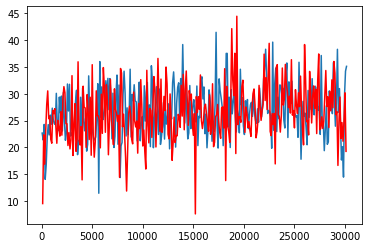

In [6]:
import matplotlib.pyplot as plt
plt.plot(epoch_array1, psnr_array1)
plt.plot(epoch_array2, psnr_array2,color='red')

In [7]:
with open('psnr.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        print(row)

['50', '22.66575445362053']
['100', '9.514690062421876']
['150', '21.364931987968305']
['200', '22.334609351006325']
['250', '24.28452444800741']
['300', '16.863043946829855']
['350', '14.031581821817419']
['400', '23.060276625703963']
['450', '16.751356248877006']
['500', '27.999358972324742']
['550', '21.86552818078685']
['600', '30.54271084615261']
['650', '24.2487394971647']
['700', '25.348653609072823']
['750', '22.32823076480352']
['800', '25.77934312257748']
['850', '26.029223644141858']
['900', '21.493806003132974']
['950', '24.303876017969188']
['1000', '20.777903767423304']
['1050', '27.32261716356686']
['1100', '26.91436748817886']
['1150', '25.137600511541642']
['1200', '26.27852283319794']
['1250', '24.450263062840243']
['1300', '27.227127620101616']
['1350', '24.271633287473136']
['1400', '23.81500910560269']
['1450', '30.0867949491435']
['1500', '20.76814956237286']
['1550', '23.868246128751114']
['1600', '25.027886532303558']
['1650', '23.12768294088505']
['1700', '23.7

In [8]:
class Generate(SRGAN):
    def generate(self, batch_size=1, sample_interval=50):
        BATCH_SIZE=1
        ite=10000
        def denormalize(input_data):
            input_data = (input_data + 1) * 127.5
            return input_data.astype(np.uint8)
            
        self.generator = self.build_generator()
        g = self.generator
        g.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
        g.load_weights('srg_weight.h5')
        for i in range(10):
            noise = np.random.uniform(size=[BATCH_SIZE, 480*640*3], low=-1.0, high=1.0)
            imgs_or = self.pred_data_loader.load_data(batch_size=1,counter=i)
            # imgs_hr, imgs_or = self.data_loader.load_data(batch_size=BATCH_SIZE,is_testing=True)

            plt.imshow(denormalize(imgs_or[0]))
            plt.pause(1)
            noise=imgs_or.reshape(BATCH_SIZE,480,640,3)
            generated_images = g.predict(noise)
            plt.imshow(denormalize(generated_images[0]))
            plt.pause(1)
            p_im=Image.fromarray(denormalize(generated_images[0]))
            p_im.save('../../images/output/p_im_{}.png'.format(i))
            # plt.imshow(p_im.resize((120,120)), Image.LANCZOS)

            print(i)
        # os.makedirs(os.path.join(".", "images"), exist_ok=True)
        # image.save("./images/%s%d.png" % (ite,i))            

    def combine_images(generated_images, cols=5, rows=5):
        shape = generated_images.shape
        h = shape[1]
        w = shape[2]
        image = np.zeros((rows * h,  cols * w, 3))
        for index, img in enumerate(generated_images):
            if index >= cols * rows:
                break
            i = index // cols
            j = index % cols
            image[i*h:(i+1)*h, j*w:(j+1)*w, :] = img[:, :, :]
        image = image * 127.5 + 127.5
        image = Image.fromarray(image.astype(np.uint8))
        
        return image

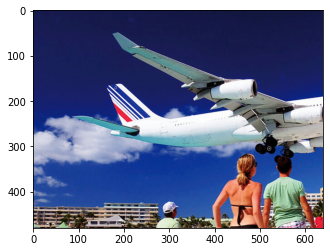

ValueError: Error when checking : expected input_27 to have shape (None, 120, 160, 3) but got array with shape (1, 480, 640, 3)

In [19]:
if __name__ == '__main__':
    gene = Generate()
    gene.generate(batch_size=1, sample_interval=1000)